In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings(action='once')
import xgboost as xgb
from sklearn import model_selection
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

/anaconda/lib/python3.6/importlib/_bootstrap.py:205: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
/anaconda/lib/python3.6/importlib/_bootstrap.py:205: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)


In [2]:
trainbog=pd.read_csv("/Users/sandip/Data/Analytic_vidhya/BoG/train_zsTMYVA/train.csv")
testbog=pd.read_csv("/Users/sandip/Data/Analytic_vidhya/BoG/test.csv")
trainbog.head()

/anaconda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (294,299,300,302,307,313,315,365,367,369) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/anaconda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (294,299,300,302,313,315,365,367,369) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


UCIC_ID  NO_OF_Accs HNW_CATEGORY  vintage EMAIL_UNSUBSCRIBE  OCCUP_ALL_NEW  \
0   170114           1  2_Preferred     1947               NaN      HOUSEWIFE   
1   488013           1    1_Imperia     3082               NaN       SALARIED   
2   435239           1  2_Preferred      572               NaN  SELF_EMPLOYED   
3   331646           1    3_Classic      773               NaN  SELF_EMPLOYED   
4   226900           1  2_Preferred     1627               NaN      HOUSEWIFE   

        city  dependents       zip FINAL_WORTH_prev1     ...      \
0  BANGALORE         0.0  562114.0              HIGH     ...       
1     MUMBAI         0.0  400015.0              HIGH     ...       
2       HILI         NaN  733126.0              HIGH     ...       
3   NAMAKKAL         0.0  637410.0              HIGH     ...       
4     MUMBAI         0.0  400053.0              HIGH     ...       

  Query_Resolved_PrevQ1  Complaint_Logged_PrevQ1  Complaint_Resolved_PrevQ1  \
0                   NaN                      NaN                        NaN   
1                   NaN                      NaN                        NaN   
2                   NaN                      NaN                        NaN   
3                   NaN                      NaN                        NaN   
4                   NaN                      NaN                        NaN   

   NO_OF_CHEQUE_BOUNCE_V1  Percent_Change_in_Credits  \
0                     NaN                 -94.757314   
1                     NaN                 160.024566   
2                     NaN                 273.771918   
3                     NaN                        NaN   
4                     NaN                 399.997265   

   Percent_Change_in_FT_Bank  Percent_Change_in_FT_outside  \
0                        NaN                           0.0   
1                        NaN                           0.0   
2                        NaN                          10.0   
3                        NaN                           NaN   
4                        NaN                           7.0   

   Percent_Change_in_Self_Txn  Percent_Change_in_Big_Expenses  Responders  
0                         NaN                             NaN           0  
1                         NaN                             0.0           0  
2                         NaN                             NaN           1  
3                         NaN                             NaN           0  
4                         NaN                             NaN           0  

[5 rows x 377 columns]

In [3]:
print(trainbog.shape)
print(testbog.shape)

(300000, 377)
(200000, 376)


In [4]:
trainbog.isnull().sum(axis=0).sort_values(ascending=False)

CC_PREM_CLOSED_PREVQ1        300000
EDU_Closed_PrevQ1            300000
TL_PREM_CLOSED_PREVQ1        300000
EDU_PREM_CLOSED_PREVQ1       300000
TL_Closed_PrevQ1             299999
LAS_TAG_LIVE                 299999
LAS_DATE                     299999
CE_PREM_CLOSED_PREVQ1        299996
EDU_DATE                     299989
EDU_TAG_LIVE                 299989
CE_Closed_PrevQ1             299988
CV_PREM_CLOSED_PREVQ1        299988
TWL_PREM_CLOSED_PREVQ1       299982
AGRI_Closed_PrevQ1           299981
AGRI_PREM_CLOSED_PREVQ1      299981
AGRI_DATE                    299980
AGRI_TAG_LIVE                299980
TL_DATE                      299955
TL_TAG_LIVE                  299955
FRX_PrevQ1                   299939
CV_Closed_PrevQ1             299924
AL_CNC_PREM_CLOSED_PREVQ1    299914
TWL_Closed_PrevQ1            299879
PL_PREM_CLOSED_PREVQ1        299872
AL_CNC_Closed_PrevQ1         299871
CE_TAG_LIVE                  299859
CE_DATE                      299859
BL_PREM_CLOSED_PREVQ1       

In [5]:
nullvalues = trainbog.isnull().sum(axis=0)
ndf=nullvalues.to_frame()

In [6]:
ndf[ndf.values>250000].count()

0    106
dtype: int64

In [7]:
trainbog["Responders"].value_counts()

0    248303
1     51697
Name: Responders, dtype: int64

In [8]:
trainbog.dtypes.value_counts()

float64    234
int64      105
object      38
dtype: int64

In [3]:
catvar=trainbog.select_dtypes(exclude=["int64","float64"])
norvar=trainbog.select_dtypes(exclude=["object"])
catvar["Req_Resolved_PrevQ1"].loc[catvar['Req_Resolved_PrevQ1']==">"] = None
catvar["Query_Resolved_PrevQ1"].loc[catvar['Query_Resolved_PrevQ1']==">"] = None
catvar["Complaint_Resolved_PrevQ1"].loc[catvar['Complaint_Resolved_PrevQ1']==">"] = None
catvar[['Req_Resolved_PrevQ1','Query_Resolved_PrevQ1', 'Complaint_Resolved_PrevQ1']] = catvar[['Req_Resolved_PrevQ1','Query_Resolved_PrevQ1', 'Complaint_Resolved_PrevQ1']].astype(float)
lastvar= catvar[['Req_Resolved_PrevQ1','Query_Resolved_PrevQ1', 'Complaint_Resolved_PrevQ1']]
catvar=catvar.drop(catvar[['Req_Resolved_PrevQ1','Query_Resolved_PrevQ1', 'Complaint_Resolved_PrevQ1']],axis=1)
catvar[['AGRI_TAG_LIVE', 'AL_CNC_TAG_LIVE', 'AL_TAG_LIVE', 'BL_TAG_LIVE','CC_TAG_LIVE', 'CE_TAG_LIVE', 'CV_TAG_LIVE', 'DEMAT_TAG_LIVE','EDU_TAG_LIVE', 'GL_TAG_LIVE', 'HL_TAG_LIVE', 'SEC_ACC_TAG_LIVE','INS_TAG_LIVE', 'LAS_TAG_LIVE', 'MF_TAG_LIVE', 'OTHER_LOANS_TAG_LIVE','PL_TAG_LIVE', 'RD_TAG_LIVE', 'FD_TAG_LIVE', 'TL_TAG_LIVE','TWL_TAG_LIVE', 'lap_tag_live']]=catvar[['AGRI_TAG_LIVE', 'AL_CNC_TAG_LIVE', 'AL_TAG_LIVE', 'BL_TAG_LIVE','CC_TAG_LIVE', 'CE_TAG_LIVE', 'CV_TAG_LIVE', 'DEMAT_TAG_LIVE','EDU_TAG_LIVE', 'GL_TAG_LIVE', 'HL_TAG_LIVE', 'SEC_ACC_TAG_LIVE','INS_TAG_LIVE', 'LAS_TAG_LIVE', 'MF_TAG_LIVE', 'OTHER_LOANS_TAG_LIVE','PL_TAG_LIVE', 'RD_TAG_LIVE', 'FD_TAG_LIVE', 'TL_TAG_LIVE','TWL_TAG_LIVE', 'lap_tag_live']].fillna('N')
catvar[['EMAIL_UNSUBSCRIBE']]=catvar[['EMAIL_UNSUBSCRIBE']].fillna('N')

/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/anaconda/lib/python3.6/site-packages/pandas/core/frame.py:2450: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


In [4]:
def getCityFromZip(citycode,city):
    #print(city)
    #print(citycode)
    if pd.isnull(citycode):
        #print("r2")
        return np.nan
    elif pd.isnull(city):
        #print("r1")
        x=temp.loc[temp.zip==citycode]['city']
        if x.empty:
            return np.nan
        else:
            #print(x.iloc[0])
            return x.iloc[0]
    else:
        #print(city)
        return city
temp=trainbog.loc[trainbog['city'].notnull()]
catvar["city"]=trainbog.apply(lambda x : getCityFromZip(x['zip'],x['city']),axis=1)

In [5]:
catvar[['OCCUP_ALL_NEW']]=catvar[['OCCUP_ALL_NEW']].fillna('MISSING')
catvar[['FINAL_WORTH_prev1']]=catvar[['FINAL_WORTH_prev1']].fillna('MEDIUM')
catvar[['ENGAGEMENT_TAG_prev1']]=catvar[['ENGAGEMENT_TAG_prev1']].fillna('LOW')

In [6]:
trainbog['city']=catvar['city']
catvar[['city']]=catvar[['city']].fillna('xyz')
trainbog[['zip']]=trainbog[['zip']].fillna(123456.0)

In [8]:
norvar[['zip']]=trainbog[['zip']]

/anaconda/lib/python3.6/site-packages/pandas/core/frame.py:2450: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


In [7]:
norvar[['AGRI_PREM_CLOSED_PREVQ1','AL_CNC_PREM_CLOSED_PREVQ1','AL_PREM_CLOSED_PREVQ1','BL_PREM_CLOSED_PREVQ1','CC_PREM_CLOSED_PREVQ1','CE_PREM_CLOSED_PREVQ1','CV_PREM_CLOSED_PREVQ1','EDU_PREM_CLOSED_PREVQ1','OTHER_LOANS_PREM_CLOSED_PREVQ1','PL_PREM_CLOSED_PREVQ1','RD_PREM_CLOSED_PREVQ1','FD_PREM_CLOSED_PREVQ1','TL_PREM_CLOSED_PREVQ1','TWL_PREM_CLOSED_PREVQ1','AGRI_Closed_PrevQ1','AL_CNC_Closed_PrevQ1','AL_Closed_PrevQ1','BL_Closed_PrevQ1','CC_CLOSED_PREVQ1','CE_Closed_PrevQ1','CV_Closed_PrevQ1','EDU_Closed_PrevQ1','GL_Closed_PrevQ1','OTHER_LOANS_Closed_PrevQ1','PL_Closed_PrevQ1','RD_CLOSED_PREVQ1','FD_CLOSED_PREVQ1','TL_Closed_PrevQ1','TWL_Closed_PrevQ1','DEMAT_CLOSED_PREV1YR','SEC_ACC_CLOSED_PREV1YR']]=norvar[['AGRI_PREM_CLOSED_PREVQ1','AL_CNC_PREM_CLOSED_PREVQ1','AL_PREM_CLOSED_PREVQ1','BL_PREM_CLOSED_PREVQ1','CC_PREM_CLOSED_PREVQ1','CE_PREM_CLOSED_PREVQ1','CV_PREM_CLOSED_PREVQ1','EDU_PREM_CLOSED_PREVQ1','OTHER_LOANS_PREM_CLOSED_PREVQ1','PL_PREM_CLOSED_PREVQ1','RD_PREM_CLOSED_PREVQ1','FD_PREM_CLOSED_PREVQ1','TL_PREM_CLOSED_PREVQ1','TWL_PREM_CLOSED_PREVQ1','AGRI_Closed_PrevQ1','AL_CNC_Closed_PrevQ1','AL_Closed_PrevQ1','BL_Closed_PrevQ1','CC_CLOSED_PREVQ1','CE_Closed_PrevQ1','CV_Closed_PrevQ1','EDU_Closed_PrevQ1','GL_Closed_PrevQ1','OTHER_LOANS_Closed_PrevQ1','PL_Closed_PrevQ1','RD_CLOSED_PREVQ1','FD_CLOSED_PREVQ1','TL_Closed_PrevQ1','TWL_Closed_PrevQ1','DEMAT_CLOSED_PREV1YR','SEC_ACC_CLOSED_PREV1YR']].fillna(0.0)
        
        
        

/anaconda/lib/python3.6/site-packages/pandas/core/frame.py:2450: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


In [28]:
#Recency_of_Activity null values replaced by 
norvar[['dependents']]=norvar[['dependents']].fillna(0.0)
norvar[['Recency_of_Activity']]=norvar[['Recency_of_Activity']].fillna(-1.0)
norvar[['Recency_of_BRANCH_TXN']]=norvar[['Recency_of_BRANCH_TXN']].fillna(-1.0)
norvar[['Recency_of_DR_TXN']]=norvar[['Recency_of_DR_TXN']].fillna(-1.0)
norvar[['Recency_of_CR_TXN']]=norvar[['Recency_of_CR_TXN']].fillna(-1.0)


/anaconda/lib/python3.6/site-packages/pandas/core/frame.py:2450: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


In [39]:
x=norvar.isnull().sum(axis=0)
x.value_counts()

0         235
299708      4
297114      4
299704      2
122657      2
126456      2
235277      2
263934      2
114828      2
299718      2
299706      2
263856      2
210311      2
212630      2
266388      2
115852      2
119421      2
299643      2
264854      2
214102      2
211491      2
215340      2
210710      2
238584      2
265716      2
233969      2
235206      2
116621      2
236286      2
233924      2
         ... 
272500      1
275037      1
153682      1
291368      1
285215      1
237204      1
231094      1
297866      1
228502      1
270731      1
179500      1
297821      1
299859      1
196945      1
299328      1
230204      1
135988      1
298286      1
232863      1
299939      1
296724      1
275370      1
296197      1
154370      1
298738      1
299242      1
228562      1
299955      1
274111      1
259577      1
Length: 71, dtype: int64

In [5]:
lastvar[pd.notnull(lastvar["Complaint_Resolved_PrevQ1"])].head(10)

Req_Resolved_PrevQ1 Query_Resolved_PrevQ1 Complaint_Resolved_PrevQ1
3123                  NaN                   NaN                         3
8366                  NaN                     2                         1
9370                  NaN                     3                         3
9687                  NaN                   NaN                         2
10652                 NaN                   NaN                       1.0
10702                   6                   NaN                       4.0
10761                 NaN                   NaN                       3.0
12048                 0.0                   NaN                       1.0
17338                 NaN                   NaN                         2
19339                 NaN                   NaN                         1

In [13]:
catvar["AGRI_TAG_LIVE"].value_counts()

Y    20
Name: AGRI_TAG_LIVE, dtype: int64

In [13]:
">" in catvar["Req_Resolved_PrevQ1"].value_counts()

KeyError: 'Req_Resolved_PrevQ1'

In [12]:
ols = (catvar == ">").any()[lambda x: x].index
catvar[ols].head()

Empty DataFrame
Columns: []
Index: [0, 1, 2, 3, 4]

In [41]:
encoded_x = None
for i in range(0, catvar.shape[1]):
    label_encoder = LabelEncoder()
    feature = label_encoder.fit_transform(catvar.iloc[:,i])
    feature = feature.reshape(catvar.shape[0], 1)
    onehot_encoder = OneHotEncoder(sparse=False)
    feature = onehot_encoder.fit_transform(feature)
    if encoded_x is None:
        encoded_x = feature
    else:
        encoded_x = np.concatenate((encoded_x, feature), axis=1)
print("X shape: : ", encoded_x.shape)

X shape: :  (300000, 4168)


In [45]:
#encoded_x.dump("/Users/sandip/Data/Analytic_vidhya/BoG/catvar.dat")
np.save("/Users/sandip/Data/Analytic_vidhya/BoG/catvar.npy",encoded_x,allow_pickle=True,fix_imports=True)
            

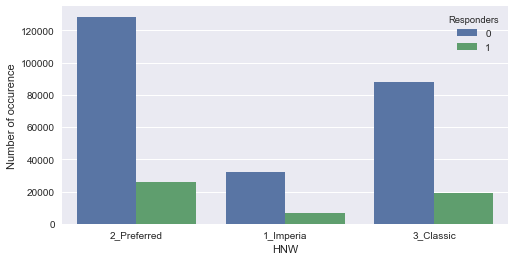

In [20]:
cnt_srs=catvar.HNW_CATEGORY.value_counts()
plt.figure(figsize=(8,4))
sns.countplot(data=catvar,x="HNW_CATEGORY",hue='Responders')
plt.ylabel("Number of occurence")
plt.xlabel('HNW')
plt.show()

In [15]:
catvar["Responders"]=trainbog["Responders"]

In [21]:
catvar.Responders.value_counts()

0    248303
1     51697
Name: Responders, dtype: int64

In [23]:
testbog.head(5)

UCIC_ID  NO_OF_Accs HNW_CATEGORY  vintage EMAIL_UNSUBSCRIBE  OCCUP_ALL_NEW  \
0   337734           2  2_Preferred      463               NaN       SALARIED   
1   488166           1    1_Imperia     3822               NaN        RETIRED   
2   410785           1  2_Preferred      682               NaN  SELF_EMPLOYED   
3   389145           1  2_Preferred      552               NaN  SELF_EMPLOYED   
4   221090           1  2_Preferred     2018               NaN  SELF_EMPLOYED   

        city  dependents       zip FINAL_WORTH_prev1  \
0   THRISSUR         0.0  680751.0              HIGH   
1  JALANDHAR         0.0  144001.0              HIGH   
2  NEW DELHI         2.0  110030.0              HIGH   
3      SURAT         0.0  395001.0              HIGH   
4     MUMBAI         0.0  400066.0              HIGH   

                ...               Query_Logged_PrevQ1  Query_Resolved_PrevQ1  \
0               ...                               NaN                    NaN   
1               ...                               NaN                    NaN   
2               ...                               NaN                    NaN   
3               ...                               NaN                    NaN   
4               ...                               NaN                    NaN   

   Complaint_Logged_PrevQ1  Complaint_Resolved_PrevQ1  NO_OF_CHEQUE_BOUNCE_V1  \
0                      NaN                        NaN                     NaN   
1                      NaN                        NaN                     NaN   
2                      NaN                        NaN                     NaN   
3                      NaN                        NaN                     NaN   
4                      NaN                        NaN                     NaN   

   Percent_Change_in_Credits  Percent_Change_in_FT_Bank  \
0                  65.591291                        NaN   
1                  33.333333                        NaN   
2                        NaN                        NaN   
3                 159.128386                        NaN   
4                  39.529538                        NaN   

   Percent_Change_in_FT_outside  Percent_Change_in_Self_Txn  \
0                           1.0                         NaN   
1                           NaN                         NaN   
2                           NaN                         NaN   
3                          41.0                         NaN   
4                           1.0                         NaN   

   Percent_Change_in_Big_Expenses  
0                             NaN  
1                             NaN  
2                             NaN  
3                             0.0  
4                             7.0  

[5 rows x 376 columns]

In [27]:
trainbog[["UCIC_ID"]][~trainbog[["UCIC_ID"]].index.isin(testbog[["UCIC_ID"]].index)].count()

UCIC_ID    100000
dtype: int64

In [28]:
testbog.shape

(200000, 376)

In [30]:
testbog[["UCIC_ID"]][~testbog[["UCIC_ID"]].index.isin(trainbog[["UCIC_ID"]].index)].count()

UCIC_ID    0
dtype: int64

In [33]:
trainbog[trainbog["UCIC_ID"]==389145]

Empty DataFrame
Columns: [UCIC_ID, NO_OF_Accs, HNW_CATEGORY, vintage, EMAIL_UNSUBSCRIBE, OCCUP_ALL_NEW, city, dependents, zip, FINAL_WORTH_prev1, ENGAGEMENT_TAG_prev1, C_prev1, D_prev1, ATM_C_prev1, ATM_D_prev1, BRANCH_C_prev1, BRANCH_D_prev1, IB_C_prev1, IB_D_prev1, MB_C_prev1, MB_D_prev1, POS_C_prev1, POS_D_prev1, count_C_prev1, count_D_prev1, COUNT_ATM_C_prev1, COUNT_ATM_D_prev1, COUNT_BRANCH_C_prev1, COUNT_BRANCH_D_prev1, COUNT_IB_C_prev1, COUNT_IB_D_prev1, COUNT_MB_C_prev1, COUNT_MB_D_prev1, COUNT_POS_C_prev1, COUNT_POS_D_prev1, custinit_CR_amt_prev1, custinit_DR_amt_prev1, custinit_CR_cnt_prev1, custinit_DR_cnt_prev1, ATM_amt_prev1, ATM_CW_Amt_prev1, ATM_CW_Cnt_prev1, BRN_CW_Amt_prev1, BRN_CW_Cnt_prev1, BRN_CASH_Dep_Amt_prev1, BRN_CASH_Dep_Cnt_prev1, CNR_prev1, BAL_prev1, EOP_prev1, CR_AMB_Prev1, C_prev2, D_prev2, ATM_C_prev2, ATM_D_prev2, BRANCH_C_prev2, BRANCH_D_prev2, IB_C_prev2, IB_D_prev2, MB_C_prev2, MB_D_prev2, POS_C_prev2, POS_D_prev2, count_C_prev2, count_D_prev2, COUNT_ATM_C_prev2, COUNT_ATM_D_prev2, COUNT_BRANCH_C_prev2, COUNT_BRANCH_D_prev2, COUNT_IB_C_prev2, COUNT_IB_D_prev2, COUNT_MB_C_prev2, COUNT_MB_D_prev2, COUNT_POS_C_prev2, COUNT_POS_D_prev2, custinit_CR_amt_prev2, custinit_DR_amt_prev2, custinit_CR_cnt_prev2, custinit_DR_cnt_prev2, ATM_amt_prev2, ATM_CW_Amt_prev2, ATM_CW_Cnt_prev2, BRN_CW_Amt_prev2, BRN_CW_Cnt_prev2, BRN_CASH_Dep_Amt_prev2, BRN_CASH_Dep_Cnt_prev2, CNR_prev2, BAL_prev2, EOP_prev2, CR_AMB_Prev2, C_prev3, D_prev3, ATM_C_prev3, ATM_D_prev3, BRANCH_C_prev3, BRANCH_D_prev3, IB_C_prev3, IB_D_prev3, MB_C_prev3, MB_D_prev3, POS_C_prev3, ...]
Index: []

[0 rows x 377 columns]

In [21]:
catvar[['AGRI_TAG_LIVE', 'AL_CNC_TAG_LIVE', 'AL_TAG_LIVE', 'BL_TAG_LIVE','CC_TAG_LIVE', 'CE_TAG_LIVE', 'CV_TAG_LIVE', 'DEMAT_TAG_LIVE','EDU_TAG_LIVE', 'GL_TAG_LIVE', 'HL_TAG_LIVE', 'SEC_ACC_TAG_LIVE','INS_TAG_LIVE', 'LAS_TAG_LIVE', 'MF_TAG_LIVE', 'OTHER_LOANS_TAG_LIVE','PL_TAG_LIVE', 'RD_TAG_LIVE', 'FD_TAG_LIVE', 'TL_TAG_LIVE','TWL_TAG_LIVE', 'lap_tag_live']]=catvar[['AGRI_TAG_LIVE', 'AL_CNC_TAG_LIVE', 'AL_TAG_LIVE', 'BL_TAG_LIVE','CC_TAG_LIVE', 'CE_TAG_LIVE', 'CV_TAG_LIVE', 'DEMAT_TAG_LIVE','EDU_TAG_LIVE', 'GL_TAG_LIVE', 'HL_TAG_LIVE', 'SEC_ACC_TAG_LIVE','INS_TAG_LIVE', 'LAS_TAG_LIVE', 'MF_TAG_LIVE', 'OTHER_LOANS_TAG_LIVE','PL_TAG_LIVE', 'RD_TAG_LIVE', 'FD_TAG_LIVE', 'TL_TAG_LIVE','TWL_TAG_LIVE', 'lap_tag_live']].fillna('N')
catvar[['EMAIL_UNSUBSCRIBE']]=catvar[['EMAIL_UNSUBSCRIBE']].fillna('N')

In [28]:
catvar[['EMAIL_UNSUBSCRIBE']]=catvar[['EMAIL_UNSUBSCRIBE']].fillna('N')

In [184]:
catvar[['OCCUP_ALL_NEW']]=catvar[['OCCUP_ALL_NEW']].fillna('MISSING')
catvar[['FINAL_WORTH_prev1']]=catvar[['FINAL_WORTH_prev1']].fillna('MEDIUM')
catvar[['ENGAGEMENT_TAG_prev1']]=catvar[['ENGAGEMENT_TAG_prev1']].fillna('LOW')

In [186]:
trainbog['city']=catvar['city']

In [190]:
trainbog['city']=catvar['city']
catvar[['city']]=catvar[['city']].fillna('xyz')
trainbog[['zip']]=trainbog[['zip']].fillna(123456.0)

In [15]:
x=norvar.isnull().sum(axis=0).sort_values(ascending=False)
y=x.filter(x.value_counts() > 0)

In [20]:
trainbog.shape

(300000, 377)

In [21]:
norvar.Recency_of_Activity.value_counts()

0.0       45484
3.0       17501
4.0       13300
5.0       11766
1.0       10736
6.0       10152
2.0        9798
7.0        8001
9.0        6648
11.0       6082
14.0       5943
12.0       5763
13.0       5742
10.0       5654
21.0       4979
17.0       4190
24.0       4172
18.0       4076
19.0       3936
20.0       3834
23.0       2836
28.0       2785
25.0       2757
26.0       2624
8.0        2582
27.0       2508
33.0       1839
30.0       1765
31.0       1731
32.0       1698
          ...  
2683.0        1
866.0         1
2738.0        1
911.0         1
2677.0        1
1367.0        1
3432.0        1
2737.0        1
1310.0        1
1224.0        1
1401.0        1
1950.0        1
3224.0        1
2982.0        1
3876.0        1
2410.0        1
2791.0        1
876.0         1
2648.0        1
2412.0        1
2072.0        1
2778.0        1
2777.0        1
563.0         1
2769.0        1
1955.0        1
2196.0        1
2765.0        1
2540.0        1
2047.0        1
Name: Recency_of_Activit

In [29]:
nulldataframe=catvar.isnull().sum(axis=0).sort_values(ascending=False).to_frame()

In [30]:
nulldataframe.to_csv(path_or_buf="/Users/sandip/Data/Analytic_vidhya/BoG/nulldf3.csv",sep=",")

In [13]:
testbog.isnull().sum(axis=0).sort_values(ascending=False).head(50)

LAS_DATE                          200000
EDU_Closed_PrevQ1                 200000
LAS_TAG_LIVE                      200000
CC_PREM_CLOSED_PREVQ1             200000
EDU_PREM_CLOSED_PREVQ1            200000
TL_PREM_CLOSED_PREVQ1             200000
CE_PREM_CLOSED_PREVQ1             199999
TL_Closed_PrevQ1                  199997
CE_Closed_PrevQ1                  199992
AGRI_Closed_PrevQ1                199990
AGRI_PREM_CLOSED_PREVQ1           199990
TWL_PREM_CLOSED_PREVQ1            199989
EDU_TAG_LIVE                      199987
EDU_DATE                          199987
AGRI_TAG_LIVE                     199984
AGRI_DATE                         199984
CV_PREM_CLOSED_PREVQ1             199981
TL_TAG_LIVE                       199960
TL_DATE                           199960
AL_CNC_PREM_CLOSED_PREVQ1         199959
FRX_PrevQ1                        199954
CV_Closed_PrevQ1                  199943
AL_CNC_Closed_PrevQ1              199937
TWL_Closed_PrevQ1                 199931
PL_PREM_CLOSED_P

In [41]:
temp=trainbog.loc[trainbog['city']!=None] 

In [53]:
temp=trainbog.loc[trainbog['city'].notnull()]

In [177]:
def getCityFromZip(citycode,city):
    #print(city)
    #print(citycode)
    if pd.isnull(citycode):
        #print("r2")
        return np.nan
    elif pd.isnull(city):
        #print("r1")
        x=temp.loc[temp.zip==citycode]['city']
        if x.empty:
            return np.nan
        else:
            #print(x.iloc[0])
            return x.iloc[0]
    else:
        #print(city)
        return city
catvar["city"]=trainbog.apply(lambda x : getCityFromZip(x['zip'],x['city']),axis=1)

In [56]:
temp.head()

UCIC_ID  NO_OF_Accs HNW_CATEGORY  vintage EMAIL_UNSUBSCRIBE  OCCUP_ALL_NEW  \
0   170114           1  2_Preferred     1947               NaN      HOUSEWIFE   
1   488013           1    1_Imperia     3082               NaN       SALARIED   
2   435239           1  2_Preferred      572               NaN  SELF_EMPLOYED   
3   331646           1    3_Classic      773               NaN  SELF_EMPLOYED   
4   226900           1  2_Preferred     1627               NaN      HOUSEWIFE   

        city  dependents       zip FINAL_WORTH_prev1     ...      \
0  BANGALORE         0.0  562114.0              HIGH     ...       
1     MUMBAI         0.0  400015.0              HIGH     ...       
2       HILI         NaN  733126.0              HIGH     ...       
3   NAMAKKAL         0.0  637410.0              HIGH     ...       
4     MUMBAI         0.0  400053.0              HIGH     ...       

  Query_Resolved_PrevQ1  Complaint_Logged_PrevQ1  Complaint_Resolved_PrevQ1  \
0                   NaN                      NaN                        NaN   
1                   NaN                      NaN                        NaN   
2                   NaN                      NaN                        NaN   
3                   NaN                      NaN                        NaN   
4                   NaN                      NaN                        NaN   

   NO_OF_CHEQUE_BOUNCE_V1  Percent_Change_in_Credits  \
0                     NaN                 -94.757314   
1                     NaN                 160.024566   
2                     NaN                 273.771918   
3                     NaN                        NaN   
4                     NaN                 399.997265   

   Percent_Change_in_FT_Bank  Percent_Change_in_FT_outside  \
0                        NaN                           0.0   
1                        NaN                           0.0   
2                        NaN                          10.0   
3                        NaN                           NaN   
4                        NaN                           7.0   

   Percent_Change_in_Self_Txn  Percent_Change_in_Big_Expenses  Responders  
0                         NaN                             NaN           0  
1                         NaN                             0.0           0  
2                         NaN                             NaN           1  
3                         NaN                             NaN           0  
4                         NaN                             NaN           0  

[5 rows x 377 columns]

In [142]:
temp.loc[temp.zip==637410.0]['city'].iloc[0]

'NAMAKKAL'

In [174]:
print(getCityFromZip(637410.0,np.nan))

637410.0
NAMAKKAL
NAMAKKAL


In [69]:
ca=trainbog.zip.map(lambda k : print(k))

562114.0
400015.0
733126.0
637410.0
400053.0
nan
110092.0
500009.0
110031.0
585104.0
206001.0
301709.0
679103.0
600097.0
110052.0
136118.0
202394.0
401101.0
132103.0
303007.0
700001.0
132103.0
700102.0
700019.0
147301.0
331507.0
560102.0
180012.0
273303.0
424001.0
400068.0
695013.0
416416.0
110017.0
361008.0
411040.0
400067.0
370205.0
400071.0
135001.0
411045.0
210427.0
560038.0
396171.0
560076.0
576102.0
770002.0
302019.0
144040.0
400092.0
143001.0
110065.0
560043.0
271801.0
125050.0
851218.0
400007.0
500001.0
395001.0
123401.0
788710.0
600020.0
301402.0
673105.0
201010.0
781011.0
411052.0
122001.0
110075.0
415612.0
110091.0
560040.0
335513.0
380015.0
201012.0
503003.0
136135.0
380015.0
500028.0
400055.0
560045.0
360005.0
143416.0
144001.0
226001.0
700029.0
302012.0
110014.0
144003.0
700038.0
400061.0
400068.0
497001.0
132001.0
302018.0
400007.0
328001.0
201301.0
110027.0
786602.0
424001.0
144601.0
110034.0
400005.0
401207.0
360003.0
134109.0
400057.0
144001.0
110070.0
380015.0
324005

834001.0
490001.0
143102.0
125104.0
144001.0
782445.0
274001.0
700038.0
400055.0
201301.0
560037.0
781001.0
110062.0
508116.0
600091.0
560005.0
560066.0
400064.0
560085.0
560093.0
141012.0
110092.0
110058.0
403703.0
400060.0
395007.0
600018.0
110024.0
400064.0
561203.0
141112.0
500084.0
400097.0
401208.0
403503.0
152123.0
131402.0
431514.0
700082.0
124001.0
400103.0
500072.0
700020.0
110007.0
140401.0
700064.0
600064.0
132103.0
560004.0
600044.0
792110.0
421306.0
683110.0
500003.0
147001.0
600026.0
405306.0
144208.0
492004.0
403001.0
440008.0
680517.0
110003.0
387630.0
110088.0
400705.0
452001.0
400052.0
380015.0
110062.0
560017.0
500029.0
122017.0
201301.0
400060.0
400062.0
201301.0
122001.0
400034.0
110092.0
364140.0
495450.0
131001.0
395001.0
110019.0
201301.0
151001.0
400058.0
400056.0
388540.0
700091.0
411014.0
247554.0
411038.0
400708.0
460001.0
800020.0
600029.0
382024.0
160015.0
400014.0
835302.0
452001.0
847423.0
360005.0
121001.0
250001.0
400011.0
781008.0
229001.0
226006.0
6

110051.0
141003.0
226005.0
380052.0
132103.0
122002.0
700084.0
516001.0
364001.0
400068.0
400101.0
560034.0
302021.0
411030.0
140601.0
721636.0
400081.0
140001.0
201301.0
122001.0
152116.0
560078.0
400093.0
834008.0
400008.0
110049.0
110007.0
110024.0
400036.0
403002.0
734001.0
110010.0
842001.0
141015.0
700084.0
560103.0
400026.0
110096.0
600037.0
457001.0
431601.0
422005.0
600126.0
402201.0
211003.0
474006.0
160055.0
110003.0
160020.0
600018.0
110043.0
380013.0
226012.0
400053.0
600073.0
506167.0
401202.0
380061.0
400064.0
533001.0
132024.0
388540.0
122002.0
600003.0
110070.0
500084.0
521175.0
400063.0
147001.0
560037.0
560020.0
144204.0
800001.0
410206.0
211003.0
500079.0
110005.0
122018.0
231217.0
500029.0
370615.0
392001.0
783380.0
400022.0
380015.0
110018.0
110052.0
362001.0
400020.0
500048.0
140123.0
121002.0
500054.0
421204.0
282003.0
110016.0
457887.0
501505.0
388540.0
600040.0
396191.0
400706.0
400025.0
600090.0
400062.0
122002.0
400606.0
122009.0
151203.0
500027.0
600116.0
5

110034.0
678008.0
110017.0
400005.0
201301.0
401107.0
401105.0
122002.0
600092.0
110052.0
500050.0
400076.0
400101.0
700040.0
122002.0
390024.0
500027.0
600086.0
394601.0
387001.0
110007.0
401107.0
362001.0
363035.0
122001.0
400703.0
394650.0
122101.0
110024.0
411021.0
282002.0
276305.0
141411.0
110087.0
400050.0
110016.0
132001.0
248001.0
160008.0
600018.0
143521.0
520010.0
142042.0
713216.0
400604.0
110048.0
144001.0
560022.0
400053.0
302015.0
132039.0
679330.0
110013.0
389350.0
811201.0
400053.0
382721.0
301019.0
110030.0
800007.0
110085.0
110065.0
711102.0
400056.0
110019.0
400001.0
401105.0
400020.0
400022.0
396230.0
411043.0
700075.0
110002.0
787001.0
335063.0
421301.0
144001.0
507160.0
500084.0
276403.0
141001.0
400054.0
400026.0
500072.0
226024.0
122001.0
400102.0
361006.0
751002.0
324007.0
143001.0
110024.0
400097.0
122001.0
147301.0
273303.0
560004.0
110074.0
282004.0
110005.0
122001.0
361008.0
560003.0
110019.0
121010.0
226010.0
600033.0
751007.0
400050.0
325205.0
781029.0
1

700007.0
143505.0
110091.0
396191.0
411052.0
422004.0
421301.0
206001.0
221401.0
401404.0
614101.0
110065.0
390019.0
401105.0
140603.0
271865.0
411044.0
570022.0
394601.0
122002.0
600018.0
462016.0
390021.0
110021.0
273001.0
560003.0
147203.0
305601.0
144514.0
144001.0
144001.0
160022.0
411048.0
400064.0
492001.0
411028.0
141401.0
700027.0
302020.0
700114.0
160055.0
415004.0
144001.0
723101.0
680501.0
600093.0
711101.0
824231.0
380004.0
110096.0
226016.0
400013.0
600028.0
560084.0
385520.0
530017.0
122002.0
110008.0
560066.0
411060.0
411037.0
110092.0
400092.0
110025.0
700019.0
390011.0
324007.0
500055.0
201102.0
160036.0
110003.0
700142.0
700040.0
751024.0
140112.0
800016.0
400005.0
400022.0
370421.0
700028.0
500054.0
123024.0
302021.0
136026.0
110065.0
400053.0
495006.0
132001.0
144401.0
380054.0
431001.0
110034.0
400006.0
400088.0
123401.0
110062.0
560048.0
700017.0
201012.0
600117.0
401702.0
700019.0
733129.0
500032.0
396191.0
243301.0
151001.0
135003.0
403708.0
208001.0
700017.0
3

410210.0
110034.0
700009.0
360001.0
184101.0
400053.0
500026.0
136129.0
208022.0
509001.0
500060.0
400077.0
273004.0
400610.0
530023.0
394601.0
401301.0
700084.0
201010.0
700053.0
380060.0
560004.0
411048.0
110075.0
400080.0
505501.0
110008.0
636006.0
122001.0
141112.0
123028.0
380009.0
152024.0
682028.0
141001.0
400063.0
360002.0
401208.0
211006.0
400052.0
517214.0
400706.0
125001.0
753009.0
400093.0
400067.0
182301.0
743263.0
127021.0
509103.0
737121.0
711101.0
134102.0
110057.0
370205.0
600125.0
700005.0
360575.0
226003.0
625003.0
400607.0
134109.0
360575.0
110006.0
500009.0
380009.0
575028.0
110007.0
201301.0
110087.0
110017.0
302003.0
400101.0
110034.0
110060.0
302021.0
460001.0
400606.0
560066.0
483501.0
360005.0
481001.0
600042.0
382475.0
110059.0
400102.0
500033.0
110017.0
500059.0
822101.0
110014.0
201001.0
741235.0
141002.0
505001.0
110019.0
380055.0
411027.0
400101.0
110007.0
208012.0
845438.0
273164.0
500006.0
560048.0
620023.0
400706.0
846004.0
136118.0
396230.0
560092.0
5

110034.0
400059.0
141421.0
678012.0
700072.0
208022.0
342301.0
620021.0
121003.0
400706.0
400051.0
400604.0
160040.0
400018.0
110044.0
201301.0
498001.0
110031.0
110088.0
305901.0
600024.0
370201.0
122001.0
243001.0
110070.0
201010.0
400053.0
201301.0
247001.0
600020.0
134113.0
342001.0
383430.0
221001.0
144044.0
400026.0
412101.0
403601.0
796001.0
400066.0
600030.0
682026.0
793001.0
360005.0
700020.0
700054.0
202001.0
226010.0
400703.0
394510.0
431005.0
452010.0
401107.0
576101.0
202001.0
122011.0
415110.0
560076.0
110006.0
392001.0
274402.0
400049.0
364001.0
122001.0
413517.0
221107.0
473001.0
344022.0
400050.0
500072.0
110057.0
110076.0
144001.0
670631.0
380061.0
431001.0
500049.0
364001.0
781006.0
110015.0
795128.0
421204.0
110006.0
363570.0
144626.0
400067.0
516001.0
125106.0
734001.0
505001.0
121002.0
400007.0
452018.0
400708.0
263139.0
226016.0
395007.0
470661.0
361008.0
122002.0
274402.0
210507.0
504105.0
273015.0
600016.0
560066.0
110075.0
480661.0
380058.0
193302.0
110087.0
5

176403.0
400022.0
nan
110009.0
201005.0
110065.0
680001.0
201012.0
144001.0
400052.0
422205.0
110009.0
400604.0
400101.0
110034.0
400021.0
400101.0
245101.0
211006.0
nan
700048.0
395007.0
700032.0
700120.0
221002.0
452009.0
370001.0
411048.0
500080.0
110078.0
700025.0
400054.0
305006.0
141010.0
221010.0
126113.0
400070.0
400610.0
400053.0
700074.0
143001.0
141001.0
210427.0
160031.0
431112.0
110015.0
134113.0
700074.0
737102.0
585223.0
122016.0
125076.0
160059.0
400026.0
500048.0
123401.0
201301.0
110058.0
201001.0
400701.0
576222.0
143505.0
141109.0
110031.0
403001.0
600115.0
533437.0
148020.0
560043.0
734003.0
226016.0
110015.0
110092.0
421302.0
686691.0
400020.0
700147.0
400050.0
495001.0
206122.0
395006.0
680597.0
110034.0
360530.0
458001.0
700010.0
nan
400091.0
700010.0
500032.0
160019.0
422403.0
400016.0
271801.0
222001.0
228001.0
854311.0
400091.0
400025.0
530018.0
560004.0
400092.0
160036.0
400001.0
700061.0
400016.0
201005.0
363621.0
380054.0
400052.0
390002.0
143605.0
201306.

400081.0
384002.0
431001.0
826001.0
682025.0
422402.0
141109.0
305404.0
143001.0
600018.0
364001.0
302003.0
151507.0
110028.0
854318.0
282005.0
382481.0
600079.0
122001.0
400068.0
110034.0
201012.0
802101.0
400037.0
122106.0
682307.0
700074.0
700020.0
454001.0
400067.0
400026.0
608001.0
122001.0
110085.0
600041.0
411037.0
201005.0
400703.0
396195.0
400039.0
560032.0
110025.0
110043.0
nan
560080.0
522212.0
400051.0
123029.0
400001.0
520010.0
786125.0
394210.0
400050.0
734101.0
110052.0
380005.0
400097.0
201301.0
209725.0
493116.0
110029.0
700040.0
110077.0
401107.0
400050.0
560102.0
201010.0
370001.0
110009.0
400050.0
110043.0
829104.0
110019.0
400049.0
382110.0
302003.0
241001.0
751010.0
110019.0
396230.0
400081.0
226001.0
500016.0
560016.0
560008.0
823001.0
201307.0
110049.0
380006.0
110052.0
110019.0
110034.0
560067.0
144026.0
160043.0
140604.0
844101.0
629001.0
201301.0
560094.0
400002.0
380021.0
700054.0
201301.0
400020.0
263153.0
500011.0
110034.0
160062.0
110014.0
121008.0
243001

530020.0
110034.0
396445.0
462010.0
472001.0
363641.0
600017.0
276001.0
560035.0
503224.0
411037.0
110024.0
741021.0
400071.0
410210.0
700053.0
341001.0
201301.0
110019.0
682301.0
600054.0
231219.0
331023.0
500094.0
160036.0
515001.0
401105.0
465674.0
560001.0
411033.0
110001.0
121002.0
140301.0
400095.0
411021.0
141003.0
821109.0
395007.0
401101.0
620018.0
110006.0
110096.0
133001.0
452001.0
713333.0
462001.0
700027.0
670501.0
243001.0
560078.0
324005.0
110017.0
800013.0
400049.0
144401.0
110003.0
734004.0
500003.0
452012.0
458001.0
600017.0
122001.0
110006.0
141002.0
147001.0
380058.0
800020.0
411038.0
400102.0
713103.0
410203.0
700054.0
700072.0
803118.0
400052.0
122001.0
110088.0
411001.0
603004.0
421201.0
110085.0
700019.0
411032.0
700068.0
400092.0
493773.0
325205.0
201010.0
135102.0
500008.0
700156.0
303003.0
141003.0
110024.0
411002.0
736135.0
134003.0
281403.0
380015.0
172001.0
400050.0
400080.0
146107.0
110005.0
500013.0
394330.0
243201.0
110092.0
600060.0
122002.0
146001.0
4

400058.0
608001.0
251002.0
141003.0
110008.0
400097.0
400053.0
110025.0
172001.0
533103.0
600066.0
190001.0
125055.0
743275.0
500055.0
400003.0
403720.0
400101.0
122018.0
756125.0
142001.0
600018.0
122002.0
416520.0
110092.0
600001.0
400026.0
360004.0
786001.0
110015.0
226004.0
110024.0
380061.0
400067.0
713101.0
121003.0
110003.0
151001.0
500059.0
392015.0
143001.0
110019.0
700107.0
496001.0
415001.0
303106.0
400055.0
421201.0
nan
492001.0
400706.0
713301.0
521175.0
400021.0
110018.0
110019.0
110013.0
110025.0
201305.0
201001.0
827006.0
141012.0
142001.0
122001.0
180001.0
700075.0
400077.0
400081.0
495001.0
110018.0
121001.0
110024.0
800001.0
110015.0
201011.0
452009.0
600018.0
600015.0
400004.0
132001.0
201301.0
400078.0
631603.0
208001.0
201301.0
560080.0
361001.0
110016.0
110019.0
522413.0
146001.0
400092.0
400006.0
600041.0
382481.0
384151.0
421002.0
110048.0
533435.0
560082.0
110026.0
421302.0
364002.0
380054.0
753001.0
122002.0
121008.0
411048.0
400025.0
110088.0
262122.0
400021

110049.0
221001.0
395007.0
110068.0
110018.0
144008.0
424001.0
110018.0
440008.0
400068.0
190001.0
144040.0
245101.0
221001.0
395007.0
700016.0
403715.0
400709.0
522426.0
396195.0
560102.0
110052.0
400026.0
140126.0
452009.0
122001.0
493445.0
190002.0
700075.0
400025.0
600010.0
148101.0
140001.0
400098.0
400058.0
400101.0
560094.0
276305.0
560078.0
400103.0
700055.0
492001.0
400054.0
574257.0
135001.0
700090.0
127021.0
400614.0
110045.0
110009.0
700023.0
110016.0
110085.0
721401.0
110057.0
620019.0
492001.0
400101.0
444005.0
751024.0
560085.0
431602.0
400031.0
573201.0
411028.0
273001.0
364515.0
388315.0
396210.0
400092.0
831009.0
500015.0
444001.0
110056.0
400050.0
201301.0
503001.0
411045.0
140126.0
600095.0
312601.0
110027.0
400080.0
410210.0
678012.0
497001.0
400065.0
700028.0
575026.0
560022.0
388001.0
110007.0
781038.0
400069.0
680103.0
600041.0
110070.0
700153.0
676305.0
122002.0
560046.0
600099.0
440022.0
500027.0
110048.0
700006.0
400080.0
400057.0
110006.0
400607.0
380015.0
3

400074.0
110085.0
226004.0
125051.0
421501.0
226006.0
140401.0
180001.0
271201.0
831001.0
422206.0
365535.0
450331.0
590006.0
422209.0
226024.0
141401.0
605008.0
410210.0
110019.0
500081.0
152022.0
842001.0
411007.0
110015.0
713102.0
764001.0
110032.0
110059.0
421005.0
400607.0
134109.0
803101.0
110045.0
522001.0
141126.0
600041.0
442001.0
425201.0
400056.0
110005.0
781101.0
695038.0
400018.0
395009.0
600101.0
560038.0
637406.0
400101.0
400052.0
400028.0
110037.0
125001.0
122001.0
110026.0
576213.0
110032.0
226016.0
400076.0
400092.0
400054.0
125050.0
110034.0
110025.0
110052.0
700084.0
302015.0
388001.0
530013.0
396424.0
151502.0
400077.0
244001.0
400069.0
400056.0
695011.0
nan
641038.0
560062.0
700053.0
326519.0
110032.0
769004.0
411021.0
400086.0
678506.0
845401.0
400092.0
394550.0
741103.0
400066.0
515134.0
396195.0
110027.0
400708.0
464221.0
110092.0
190010.0
281001.0
400053.0
400086.0
143001.0
683511.0
400014.0
143001.0
110074.0
800014.0
395007.0
160023.0
500008.0
401107.0
382110

160059.0
134109.0
410210.0
395007.0
400026.0
577005.0
576104.0
147203.0
700006.0
620008.0
302016.0
133001.0
800024.0
110065.0
492001.0
110075.0
141401.0
201010.0
360001.0
400097.0
275101.0
126102.0
110070.0
400066.0
201301.0
500020.0
208011.0
110019.0
151001.0
302019.0
400016.0
380061.0
485001.0
110029.0
743318.0
282003.0
110036.0
452016.0
110015.0
440022.0
400016.0
282003.0
250003.0
444001.0
400043.0
400063.0
302019.0
201301.0
302006.0
335001.0
531173.0
521165.0
271801.0
400023.0
560093.0
122002.0
403005.0
344022.0
134112.0
600037.0
110058.0
190004.0
638106.0
500050.0
363641.0
400060.0
362001.0
788710.0
110017.0
136027.0
222001.0
335803.0
600004.0
110077.0
382721.0
143001.0
627818.0
500018.0
560022.0
110059.0
122009.0
400062.0
445001.0
226010.0
411018.0
474001.0
110048.0
396445.0
360005.0
224001.0
311001.0
530016.0
800020.0
208001.0
380013.0
400097.0
110092.0
122018.0
395002.0
700007.0
261001.0
400056.0
793002.0
361001.0
600034.0
400614.0
284403.0
122002.0
110065.0
766012.0
110005.0
1

226010.0
400706.0
121009.0
400016.0
201301.0
110070.0
400104.0
181133.0
124507.0
700123.0
482002.0
560043.0
121002.0
440008.0
362001.0
226003.0
nan
273015.0
110068.0
110085.0
110063.0
400606.0
302023.0
700029.0
400058.0
422002.0
211001.0
282002.0
110019.0
560005.0
144001.0
110029.0
492001.0
400058.0
201006.0
560076.0
560036.0
110017.0
505001.0
700001.0
110057.0
600082.0
400071.0
424001.0
152024.0
110085.0
403521.0
421503.0
363641.0
110092.0
686001.0
395010.0
530017.0
396191.0
208001.0
110029.0
682306.0
401202.0
110064.0
410221.0
751001.0
110017.0
110092.0
143001.0
331022.0
152026.0
400066.0
248001.0
400054.0
400065.0
201017.0
110024.0
110009.0
226016.0
110017.0
400006.0
411037.0
201010.0
395002.0
142001.0
781009.0
144002.0
400052.0
700002.0
110019.0
422603.0
686577.0
110092.0
110023.0
201303.0
143202.0
361142.0
823001.0
282001.0
440010.0
641027.0
221001.0
206001.0
110009.0
201010.0
192301.0
110061.0
273001.0
570023.0
401303.0
121006.0
670101.0
452010.0
400063.0
841438.0
110049.0
400056

400057.0
122002.0
781022.0
208006.0
700014.0
110034.0
363641.0
143001.0
423203.0
400103.0
110006.0
400052.0
500016.0
560075.0
180002.0
400050.0
721137.0
500017.0
302023.0
144410.0
400006.0
110041.0
401303.0
143531.0
410210.0
143520.0
515865.0
400005.0
122018.0
700029.0
495677.0
180100.0
400053.0
600020.0
517501.0
412307.0
400020.0
530003.0
110018.0
682001.0
530013.0
500032.0
400101.0
212402.0
600116.0
174306.0
400007.0
110041.0
141012.0
400052.0
132001.0
110058.0
261001.0
400016.0
380060.0
400080.0
560076.0
201001.0
110034.0
721429.0
121001.0
400094.0
691553.0
110054.0
380007.0
110005.0
500003.0
411016.0
560076.0
142026.0
110063.0
144804.0
400025.0
110010.0
411060.0
391740.0
400064.0
121006.0
793103.0
781022.0
110092.0
380015.0
160036.0
390018.0
211006.0
151202.0
413801.0
411013.0
400058.0
384315.0
400022.0
471001.0
331403.0
160100.0
208005.0
400081.0
421201.0
411048.0
700064.0
395002.0
121007.0
518002.0
380016.0
400610.0
250001.0
131001.0
110001.0
401303.0
302016.0
416013.0
141010.0
4

160103.0
600018.0
361001.0
400049.0
272001.0
462026.0
122002.0
700064.0
251001.0
751003.0
226003.0
144514.0
209733.0
380014.0
363310.0
400037.0
110016.0
400050.0
210310.0
737101.0
518004.0
602117.0
680588.0
302015.0
122001.0
700025.0
160036.0
400064.0
110065.0
700020.0
713148.0
384002.0
201301.0
110026.0
713325.0
141001.0
686636.0
212601.0
110053.0
110024.0
110088.0
400060.0
560043.0
431001.0
853201.0
362630.0
180001.0
500049.0
462001.0
441601.0
500032.0
140308.0
110026.0
110060.0
263137.0
403601.0
400607.0
600020.0
124112.0
201301.0
395006.0
110043.0
825411.0
221001.0
160020.0
560078.0
124001.0
400050.0
380006.0
400706.0
110026.0
841427.0
575004.0
500081.0
140306.0
458441.0
522426.0
452001.0
121002.0
190020.0
142001.0
641028.0
834008.0
400601.0
411045.0
382424.0
362310.0
136132.0
332713.0
400067.0
140507.0
452004.0
781012.0
416520.0
400076.0
282002.0
110019.0
846004.0
160002.0
247001.0
524003.0
503001.0
201301.0
190021.0
122017.0
110005.0
201301.0
110059.0
393001.0
110031.0
110048.0
1

305801.0
700075.0
400080.0
122001.0
244001.0
271002.0
400025.0
560041.0
700007.0
688003.0
400610.0
143105.0
190011.0
734101.0
160065.0
190011.0
396230.0
600034.0
395007.0
500016.0
396001.0
143001.0
600088.0
400054.0
144001.0
125102.0
411017.0
562110.0
600033.0
421501.0
110088.0
110087.0
700026.0
110072.0
524004.0
401107.0
110084.0
620006.0
400104.0
520001.0
683102.0
395007.0
110060.0
734203.0
421301.0
250001.0
400080.0
191121.0
110003.0
641013.0
700020.0
852113.0
400074.0
600119.0
122015.0
826001.0
390010.0
143505.0
444101.0
202002.0
110092.0
382340.0
160067.0
600090.0
263139.0
788360.0
121001.0
212217.0
600020.0
110052.0
500073.0
395007.0
600044.0
752050.0
500090.0
160055.0
122018.0
683513.0
700135.0
413709.0
110019.0
500008.0
110062.0
643104.0
380005.0
470001.0
380015.0
400014.0
625003.0
411020.0
144301.0
160047.0
400052.0
121009.0
686532.0
423107.0
845303.0
737126.0
400101.0
400009.0
110051.0
382870.0
147001.0
400103.0
600047.0
416416.0
822124.0
201001.0
110044.0
400065.0
831011.0
1

122001.0
400072.0
110019.0
110024.0
110046.0
134109.0
400081.0
700032.0
382721.0
422009.0
700059.0
201310.0
110010.0
450331.0
524201.0
121001.0
146001.0
400014.0
141401.0
425001.0
575003.0
500011.0
133302.0
389151.0
400007.0
400058.0
122001.0
411028.0
144001.0
390010.0
736135.0
110034.0
700094.0
700070.0
400071.0
794002.0
400030.0
273005.0
400016.0
110048.0
400022.0
400054.0
421201.0
110077.0
131029.0
143521.0
421306.0
522001.0
122002.0
160030.0
700064.0
212601.0
504208.0
302017.0
700156.0
400101.0
400059.0
700009.0
302021.0
390019.0
600098.0
734005.0
731224.0
143115.0
401209.0
600020.0
700078.0
302018.0
641018.0
700094.0
110037.0
302015.0
607002.0
400067.0
243122.0
500072.0
110048.0
209625.0
605758.0
560093.0
143001.0
400022.0
144201.0
600004.0
132001.0
515001.0
400103.0
190002.0
400058.0
364001.0
121003.0
600024.0
110016.0
500087.0
414001.0
600015.0
400067.0
411021.0
226005.0
110043.0
636302.0
152116.0
700029.0
600041.0
400605.0
110075.0
201002.0
421503.0
401601.0
414002.0
560035.0
6

273164.0
110091.0
396191.0
110044.0
110016.0
125051.0
134109.0
110074.0
462001.0
505001.0
575001.0
146105.0
323001.0
335524.0
500057.0
110033.0
385535.0
122002.0
400053.0
560025.0
560085.0
110060.0
635601.0
110024.0
670597.0
679330.0
110009.0
146109.0
600041.0
202127.0
600086.0
508207.0
422008.0
400057.0
500045.0
635109.0
560016.0
110085.0
517501.0
641012.0
560077.0
493773.0
500050.0
201014.0
223103.0
302001.0
400061.0
401207.0
400055.0
144205.0
122001.0
144040.0
382415.0
390007.0
400612.0
682035.0
500035.0
123401.0
110065.0
700135.0
400043.0
400058.0
143512.0
395007.0
395003.0
134112.0
678004.0
403707.0
500049.0
783332.0
251001.0
380006.0
411027.0
171001.0
380015.0
122050.0
110088.0
110018.0
756001.0
141001.0
380007.0
110070.0
500034.0
800006.0
641041.0
400049.0
122001.0
391740.0
166055.0
370110.0
110048.0
143501.0
143001.0
201301.0
160047.0
560017.0
639002.0
395009.0
445204.0
600026.0
271202.0
110059.0
400036.0
400002.0
176077.0
400708.0
682301.0
400051.0
400080.0
560066.0
678012.0
1

500018.0
411028.0
380015.0
400007.0
700038.0
110048.0
363642.0
201301.0
133103.0
110034.0
641601.0
382480.0
160068.0
201304.0
147103.0
501505.0
110049.0
400064.0
800020.0
400057.0
700019.0
400062.0
560035.0
400028.0
400056.0
400607.0
190001.0
400050.0
262802.0
144040.0
201010.0
324001.0
110044.0
560102.0
700064.0
201306.0
208022.0
396191.0
110041.0
505301.0
411030.0
394330.0
144101.0
400097.0
691012.0
503001.0
160071.0
122011.0
400054.0
144208.0
411017.0
226007.0
143514.0
110058.0
400036.0
380007.0
581307.0
400604.0
110092.0
122001.0
415004.0
110053.0
410210.0
700075.0
136027.0
208012.0
600084.0
394601.0
834002.0
180001.0
639002.0
411028.0
122001.0
125001.0
520010.0
342001.0
110024.0
110052.0
400007.0
141114.0
190010.0
440015.0
335513.0
700005.0
312001.0
122105.0
160008.0
244713.0
673012.0
364001.0
560027.0
517299.0
600041.0
110015.0
431203.0
422401.0
411057.0
700137.0
834001.0
144601.0
382350.0
600034.0
682030.0
110055.0
302015.0
500068.0
690510.0
395007.0
500033.0
560095.0
389350.0
n

122009.0
700053.0
400049.0
743248.0
151203.0
400006.0
224122.0
110049.0
700026.0
400092.0
395002.0
380008.0
144211.0
560093.0
400060.0
110028.0
110055.0
781001.0
136027.0
380059.0
134109.0
121001.0
201005.0
nan
600001.0
700094.0
502103.0
400067.0
228001.0
121009.0
400103.0
495006.0
134109.0
500003.0
680011.0
110017.0
516115.0
461111.0
160055.0
110034.0
140401.0
695011.0
411014.0
411028.0
400601.0
624619.0
400069.0
560048.0
411021.0
464221.0
387620.0
142050.0
506015.0
141415.0
141418.0
143001.0
122002.0
452009.0
388250.0
626189.0
560066.0
147001.0
204101.0
734301.0
411040.0
390002.0
400054.0
122009.0
110096.0
600040.0
400052.0
440008.0
123401.0
560042.0
682026.0
110035.0
562112.0
144001.0
411013.0
600078.0
110068.0
700065.0
226017.0
700046.0
231216.0
700020.0
500034.0
110025.0
482001.0
523240.0
400061.0
700029.0
400054.0
110009.0
380015.0
600100.0
122016.0
500074.0
635109.0
342008.0
400092.0
400709.0
530017.0
401404.0
500008.0
363530.0
560043.0
380008.0
382424.0
110048.0
274406.0
641046

121001.0
110014.0
682039.0
530007.0
600062.0
400081.0
274001.0
400101.0
144001.0
828110.0
811317.0
110057.0
530002.0
395009.0
302001.0
110005.0
370421.0
400074.0
370201.0
124001.0
400080.0
110014.0
403602.0
144022.0
360001.0
277001.0
560061.0
781009.0
682301.0
110085.0
122001.0
570017.0
713303.0
600083.0
190009.0
122003.0
600079.0
122017.0
485771.0
110009.0
380060.0
400089.0
247001.0
230001.0
211001.0
141012.0
700032.0
560025.0
795007.0
560064.0
422013.0
400062.0
370205.0
600088.0
380061.0
395006.0
560094.0
641001.0
394350.0
110062.0
403002.0
396450.0
560042.0
110058.0
134007.0
411038.0
244001.0
123001.0
400080.0
110009.0
400049.0
110087.0
110008.0
500034.0
141001.0
781005.0
395007.0
700064.0
110058.0
700040.0
201301.0
627657.0
500085.0
700065.0
560016.0
110009.0
382011.0
800014.0
141004.0
390019.0
600002.0
560076.0
390019.0
711204.0
110048.0
122001.0
390018.0
500001.0
786001.0
110063.0
110065.0
400020.0
560037.0
560032.0
678706.0
392001.0
124103.0
400049.0
416012.0
734006.0
201301.0
6

110064.0
143001.0
110019.0
416416.0
421301.0
201301.0
400053.0
403509.0
400053.0
416115.0
786146.0
396001.0
600018.0
515134.0
152113.0
221010.0
301019.0
226017.0
415002.0
143117.0
201301.0
388001.0
303108.0
121001.0
500034.0
560054.0
nan
302012.0
560004.0
124001.0
600083.0
400053.0
673005.0
110085.0
400067.0
364001.0
110031.0
500018.0
422009.0
121007.0
203205.0
110062.0
400055.0
131001.0
110034.0
380015.0
248009.0
689678.0
400064.0
190006.0
411030.0
284001.0
781016.0
284001.0
302019.0
110076.0
127031.0
520001.0
134003.0
486886.0
600017.0
370140.0
302017.0
700032.0
400103.0
244411.0
400001.0
110062.0
390002.0
125055.0
480108.0
533445.0
121003.0
110027.0
395007.0
600126.0
122001.0
400010.0
400706.0
444601.0
560103.0
110016.0
141401.0
831011.0
400054.0
560038.0
143002.0
700054.0
134112.0
560052.0
302016.0
400604.0
110009.0
nan
742101.0
400089.0
360001.0
110012.0
110087.0
462001.0
600033.0
400068.0
110077.0
679503.0
560076.0
110063.0
834005.0
110016.0
211001.0
411037.0
700064.0
110002.0
62

700054.0
444001.0
400027.0
400081.0
221001.0
110063.0
110065.0
600080.0
380015.0
500087.0
110019.0
441601.0
110086.0
110064.0
600002.0
110070.0
560041.0
400055.0
795001.0
700027.0
400097.0
642003.0
500045.0
400092.0
423203.0
400022.0
360004.0
110048.0
400092.0
500076.0
421301.0
241001.0
500017.0
614620.0
600091.0
688012.0
400076.0
411028.0
324009.0
700095.0
388001.0
700026.0
110070.0
521001.0
689121.0
400071.0
110015.0
713301.0
390021.0
250004.0
282004.0
141116.0
452010.0
176210.0
560049.0
442907.0
122001.0
363310.0
221002.0
380061.0
584128.0
396001.0
335513.0
110029.0
201301.0
110076.0
400013.0
400093.0
390024.0
382424.0
382346.0
560095.0
401107.0
560004.0
400092.0
835207.0
144001.0
505325.0
345001.0
400049.0
400020.0
400606.0
160070.0
400049.0
400101.0
143001.0
641011.0
110006.0
282002.0
422013.0
201301.0
680003.0
122002.0
160071.0
400101.0
411014.0
400061.0
600101.0
635118.0
625014.0
600040.0
400002.0
124001.0
411033.0
700056.0
711110.0
400076.0
160034.0
461111.0
400036.0
522007.0
1

160047.0
380013.0
411017.0
400077.0
560004.0
143001.0
576104.0
713216.0
400059.0
500090.0
122011.0
171002.0
400088.0
224230.0
121001.0
403709.0
110033.0
110070.0
396191.0
390017.0
500089.0
700048.0
380014.0
110092.0
125033.0
110005.0
753008.0
400053.0
795106.0
302004.0
680682.0
400077.0
394518.0
516454.0
110070.0
500061.0
700020.0
141010.0
125055.0
831003.0
585225.0
141001.0
700015.0
590011.0
152107.0
411002.0
700001.0
380013.0
570002.0
400610.0
400709.0
142026.0
324006.0
122003.0
122011.0
602105.0
160055.0
603209.0
110051.0
500076.0
500084.0
400089.0
641037.0
700075.0
400011.0
110092.0
825412.0
831006.0
431606.0
313001.0
400075.0
133302.0
466116.0
226003.0
122003.0
380054.0
160062.0
201301.0
121002.0
110063.0
452001.0
110008.0
400056.0
160101.0
121007.0
713213.0
324005.0
560017.0
486001.0
600029.0
700009.0
144001.0
452020.0
400050.0
638001.0
390022.0
121002.0
560076.0
141002.0
110060.0
636008.0
110006.0
360575.0
400016.0
201005.0
394180.0
302021.0
110058.0
122002.0
211016.0
400064.0
2

393002.0
110005.0
400053.0
380014.0
152026.0
452002.0
194403.0
394211.0
575001.0
122024.0
141001.0
122002.0
147101.0
160036.0
400604.0
492011.0
400057.0
400053.0
131402.0
110015.0
560085.0
135001.0
421201.0
411001.0
680603.0
576222.0
400004.0
600019.0
141401.0
400021.0
221010.0
121004.0
400020.0
401208.0
600041.0
144601.0
500050.0
121001.0
600017.0
523241.0
136118.0
390002.0
518502.0
382210.0
110060.0
141013.0
680027.0
110092.0
143001.0
829122.0
282003.0
641005.0
206242.0
711101.0
110034.0
560011.0
160022.0
500010.0
600100.0
400607.0
400079.0
206244.0
560067.0
400062.0
793002.0
201302.0
122001.0
141001.0
110001.0
500028.0
144002.0
141401.0
600095.0
411048.0
560097.0
160062.0
515761.0
400019.0
400081.0
141115.0
390011.0
388530.0
700124.0
110029.0
625007.0
403711.0
110016.0
411004.0
411037.0
171225.0
400025.0
400053.0
201301.0
560064.0
274406.0
160017.0
500003.0
245101.0
243001.0
560019.0
110016.0
500081.0
141008.0
500018.0
201301.0
400601.0
400064.0
680307.0
400052.0
560050.0
383315.0
8

400060.0
400101.0
415110.0
621212.0
132001.0
131029.0
686006.0
143001.0
442001.0
700025.0
422605.0
534266.0
211011.0
400001.0
262201.0
110030.0
122101.0
500033.0
302001.0
110018.0
756113.0
711101.0
144040.0
800013.0
110065.0
713347.0
500050.0
400708.0
125104.0
500081.0
641041.0
110094.0
122001.0
700001.0
110007.0
209861.0
272207.0
680010.0
123028.0
700026.0
400054.0
410003.0
246174.0
500014.0
638052.0
560077.0
360001.0
208025.0
360002.0
226016.0
411002.0
500028.0
400098.0
500060.0
208001.0
483501.0
400091.0
400053.0
700064.0
400615.0
383255.0
121006.0
380060.0
360050.0
401107.0
400053.0
141401.0
400024.0
470002.0
143001.0
148021.0
110024.0
411040.0
500032.0
201010.0
600010.0
560003.0
nan
208003.0
144601.0
110034.0
110048.0
700026.0
515201.0
110014.0
763008.0
560047.0
400050.0
125001.0
781005.0
400050.0
421003.0
400097.0
302016.0
464001.0
400709.0
700082.0
562114.0
700020.0
517325.0
700026.0
110021.0
380019.0
400012.0
400093.0
560055.0
560102.0
209721.0
431401.0
635601.0
400709.0
400059

502336.0
144002.0
500027.0
600102.0
620024.0
695014.0
147001.0
400002.0
400092.0
400015.0
311001.0
226010.0
387620.0
110091.0
400053.0
411027.0
400099.0
641044.0
600040.0
122002.0
364001.0
110088.0
700017.0
509385.0
600050.0
560071.0
400050.0
770073.0
380007.0
400037.0
396191.0
221010.0
680687.0
110045.0
753001.0
171222.0
124001.0
110054.0
400013.0
600087.0
110064.0
144401.0
110008.0
400053.0
500016.0
400091.0
834002.0
600004.0
400014.0
411038.0
700016.0
400077.0
147003.0
110015.0
360001.0
144626.0
400020.0
400049.0
516227.0
400053.0
600101.0
361305.0
401202.0
360370.0
711101.0
133001.0
560066.0
673006.0
424001.0
700074.0
682017.0
201301.0
501505.0
132103.0
382007.0
362001.0
250002.0
141008.0
500049.0
301701.0
110019.0
400054.0
244001.0
400019.0
134203.0
145029.0
110065.0
500072.0
110065.0
400049.0
410210.0
175001.0
143514.0
581303.0
122001.0
110012.0
302015.0
122017.0
110015.0
110017.0
400068.0
152024.0
400703.0
508204.0
193108.0
440013.0
518553.0
560071.0
126116.0
110018.0
400019.0
4

360001.0
228001.0
500034.0
603002.0
360005.0
700016.0
110017.0
686507.0
560010.0
801503.0
500073.0
146001.0
413512.0
735204.0
518002.0
700055.0
122009.0
226003.0
560097.0
802301.0
201301.0
560099.0
160036.0
560095.0
226002.0
131301.0
135001.0
403206.0
110008.0
680582.0
110015.0
530016.0
400064.0
396001.0
400703.0
380060.0
400050.0
400011.0
225407.0
211002.0
560075.0
176215.0
440018.0
110017.0
122015.0
560036.0
400018.0
788006.0
700124.0
421302.0
226021.0
400022.0
400090.0
122001.0
679121.0
400030.0
400067.0
401202.0
700009.0
410506.0
143531.0
396165.0
711106.0
411004.0
400708.0
508204.0
382424.0
110021.0
515761.0
141001.0
411028.0
132001.0
600007.0
360001.0
440012.0
143505.0
686037.0
144041.0
560048.0
110076.0
500018.0
177203.0
700027.0
600041.0
342001.0
110019.0
444001.0
793014.0
302012.0
700032.0
151001.0
713102.0
395007.0
363641.0
110029.0
600014.0
680664.0
560055.0
171002.0
380015.0
700032.0
380015.0
560032.0
401302.0
560064.0
518401.0
688003.0
516227.0
110019.0
121008.0
641029.0
4

208006.0
192301.0
110015.0
610114.0
400077.0
225001.0
400061.0
244001.0
400067.0
221002.0
127306.0
110063.0
361008.0
400099.0
144001.0
232101.0
146001.0
400025.0
182301.0
400066.0
110024.0
813102.0
144527.0
nan
400071.0
400088.0
202001.0
411001.0
713213.0
110009.0
781005.0
452010.0
248001.0
492001.0
751009.0
400036.0
412803.0
560047.0
500002.0
560094.0
400053.0
143505.0
700089.0
400064.0
121001.0
141012.0
110085.0
160015.0
110052.0
160047.0
812002.0
400010.0
360005.0
395007.0
411011.0
411002.0
110084.0
500036.0
635109.0
143001.0
160015.0
400709.0
360001.0
302001.0
600028.0
400067.0
411007.0
711102.0
363310.0
364002.0
411007.0
700059.0
122003.0
400049.0
400012.0
560068.0
370201.0
711102.0
110011.0
110027.0
560055.0
400027.0
110059.0
500073.0
482001.0
847223.0
576101.0
560078.0
623514.0
400051.0
380015.0
411032.0
680684.0
110034.0
400601.0
520013.0
110048.0
389001.0
160015.0
600040.0
400086.0
271123.0
281502.0
110048.0
411027.0
410210.0
144623.0
562101.0
400067.0
303003.0
713146.0
110016

422101.0
110031.0
400007.0
401107.0
400033.0
360531.0
243122.0
560010.0
400601.0
600014.0
143401.0
400092.0
110027.0
110054.0
676107.0
600001.0
362015.0
121001.0
160008.0
361004.0
390018.0
110024.0
400076.0
431602.0
272002.0
400050.0
380058.0
110053.0
141112.0
121003.0
560064.0
411006.0
360004.0
500045.0
380061.0
110017.0
736121.0
400002.0
331403.0
600034.0
141001.0
416005.0
263159.0
400601.0
400701.0
152107.0
680721.0
401303.0
140301.0
360001.0
791002.0
110018.0
400025.0
679309.0
614625.0
122003.0
410507.0
639104.0
600094.0
400067.0
500014.0
421301.0
121002.0
400601.0
642154.0
411016.0
700106.0
380015.0
122002.0
175001.0
110031.0
400051.0
700038.0
403523.0
590002.0
680651.0
700033.0
110057.0
110087.0
400007.0
201303.0
492001.0
560095.0
110088.0
110088.0
110062.0
400705.0
700094.0
144001.0
122001.0
110007.0
390019.0
411052.0
131101.0
411028.0
400078.0
526106.0
411044.0
177212.0
135001.0
421302.0
500029.0
793200.0
700056.0
143001.0
680505.0
700129.0
600090.0
682020.0
560008.0
700007.0
3

560037.0
110016.0
713212.0
751001.0
493773.0
110091.0
132001.0
110018.0
641020.0
110085.0
846004.0
302021.0
380008.0
560022.0
134109.0
248001.0
416410.0
201301.0
560043.0
560093.0
821109.0
560040.0
421302.0
160009.0
800020.0
311404.0
401501.0
110048.0
110058.0
143001.0
700017.0
400006.0
500004.0
671315.0
110077.0
208001.0
390001.0
380007.0
700103.0
110018.0
421003.0
394601.0
400058.0
135021.0
361305.0
206001.0
422205.0
422002.0
639001.0
400014.0
110002.0
160055.0
385001.0
394210.0
560032.0
600099.0
422002.0
431112.0
416004.0
110045.0
400080.0
363641.0
382007.0
302019.0
201010.0
396050.0
110053.0
743165.0
380015.0
142047.0
190008.0
110085.0
700059.0
411048.0
411030.0
411052.0
152107.0
122018.0
201301.0
110005.0
142054.0
388570.0
421003.0
560005.0
411038.0
388450.0
400703.0
560050.0
560076.0
400067.0
400005.0
462016.0
110063.0
400090.0
400063.0
470229.0
400607.0
110019.0
462016.0
209732.0
700064.0
834001.0
682024.0
700064.0
799114.0
110060.0
481001.0
492008.0
144626.0
495006.0
341306.0
1

133001.0
682005.0
803214.0
110058.0
587102.0
382350.0
400025.0
635751.0
273001.0
400607.0
160020.0
201005.0
575001.0
793002.0
396050.0
452001.0
400706.0
122001.0
140401.0
400069.0
151001.0
700059.0
395007.0
401107.0
nan
530022.0
143001.0
500096.0
201301.0
700003.0
495001.0
382845.0
110096.0
134109.0
110024.0
110063.0
201301.0
790104.0
221005.0
380061.0
395009.0
627007.0
400101.0
400058.0
712232.0
144629.0
141002.0
560034.0
141003.0
121001.0
700007.0
110024.0
560054.0
201016.0
600091.0
400050.0
502103.0
600078.0
334001.0
400071.0
360001.0
400064.0
226010.0
636001.0
144527.0
400067.0
560099.0
411006.0
122002.0
121003.0
110048.0
370201.0
152026.0
801103.0
110021.0
122001.0
700019.0
324006.0
500061.0
192123.0
110019.0
244241.0
302039.0
151203.0
422209.0
123501.0
781335.0
585103.0
302020.0
201301.0
141010.0
144621.0
143001.0
133001.0
226003.0
422005.0
110040.0
110017.0
682306.0
403110.0
411029.0
110049.0
400008.0
400077.0
600116.0
400081.0
143201.0
226005.0
403728.0
560102.0
242001.0
500050

400005.0
400019.0
785640.0
400020.0
110017.0
680613.0
152026.0
736121.0
141001.0
135001.0
134116.0
680308.0
201301.0
400081.0
302016.0
211001.0
190002.0
110085.0
805105.0
400063.0
360311.0
144403.0
400067.0
781005.0
987810.0
208002.0
474001.0
134003.0
400060.0
391440.0
682020.0
560075.0
125001.0
282002.0
110045.0
560057.0
421202.0
380015.0
380006.0
387810.0
360005.0
370001.0
110048.0
586101.0
110016.0
500057.0
500026.0
110048.0
273015.0
422005.0
110042.0
600042.0
121004.0
144008.0
360003.0
146001.0
246763.0
400016.0
400042.0
395005.0
713359.0
500094.0
370201.0
110026.0
380015.0
400019.0
411014.0
733129.0
392015.0
380052.0
110064.0
450001.0
422013.0
500062.0
144001.0
400017.0
147001.0
110054.0
411016.0
560085.0
147001.0
492010.0
324009.0
403721.0
841226.0
768222.0
400064.0
123401.0
700106.0
400016.0
271001.0
226021.0
141001.0
110046.0
180001.0
753003.0
492007.0
324005.0
700019.0
751002.0
271831.0
110051.0
141203.0
302006.0
400008.0
812001.0
600017.0
226024.0
736182.0
560043.0
700101.0
1

175001.0
363621.0
140501.0
495678.0
144007.0
110034.0
124112.0
nan
721101.0
600119.0
422005.0
400052.0
110058.0
560092.0
110075.0
110064.0
132001.0
110096.0
625016.0
160009.0
400092.0
500092.0
201014.0
136027.0
560017.0
110092.0
400092.0
221402.0
700009.0
500062.0
400019.0
621311.0
110053.0
160036.0
144001.0
247001.0
400067.0
110091.0
152123.0
400019.0
600020.0
121006.0
400062.0
768201.0
211001.0
313004.0
400088.0
400054.0
620003.0
711101.0
600028.0
680568.0
110029.0
600010.0
283203.0
121008.0
400606.0
560094.0
110085.0
211006.0
700026.0
600090.0
182205.0
400052.0
276403.0
577005.0
560099.0
110085.0
500027.0
400007.0
245101.0
600004.0
769004.0
110092.0
160059.0
400064.0
797112.0
682025.0
424001.0
110085.0
361006.0
160069.0
382715.0
680020.0
282002.0
400011.0
401303.0
421201.0
122001.0
110092.0
560037.0
144507.0
400064.0
400031.0
110070.0
226010.0
110070.0
711106.0
695002.0
400024.0
600041.0
121102.0
160059.0
396191.0
560078.0
400615.0
411082.0
712401.0
734001.0
395007.0
400054.0
400097

700027.0
560103.0
400614.0
400069.0
414003.0
302029.0
110027.0
122505.0
143001.0
401202.0
125104.0
380061.0
396001.0
122001.0
122018.0
110014.0
121008.0
412801.0
110040.0
110027.0
741101.0
400012.0
700089.0
515865.0
848101.0
145001.0
152022.0
360370.0
642126.0
560071.0
250001.0
700010.0
174402.0
110048.0
411001.0
400022.0
400055.0
273001.0
302017.0
457226.0
400052.0
144001.0
201010.0
500016.0
444303.0
400050.0
781001.0
560037.0
193221.0
110076.0
400610.0
110017.0
208001.0
324003.0
620017.0
500089.0
141414.0
600088.0
122017.0
560003.0
803101.0
411018.0
144001.0
676101.0
226003.0
110057.0
201301.0
403511.0
560003.0
380007.0
641035.0
110085.0
431001.0
403004.0
160022.0
226001.0
400102.0
380004.0
452008.0
110007.0
380019.0
413517.0
221001.0
122009.0
332001.0
786125.0
247667.0
600073.0
678501.0
144001.0
201305.0
560023.0
700016.0
370001.0
380058.0
506002.0
400067.0
136128.0
400098.0
110085.0
560102.0
244001.0
395002.0
380015.0
700064.0
110060.0
496001.0
794111.0
683104.0
768017.0
380058.0
3

201001.0
682309.0
400101.0
134203.0
600061.0
411044.0
400066.0
122001.0
679535.0
456010.0
143416.0
700040.0
190006.0
110092.0
400002.0
302004.0
492010.0
411029.0
400076.0
201301.0
152123.0
110062.0
400072.0
110085.0
600041.0
400067.0
134107.0
208002.0
243639.0
400057.0
400102.0
400039.0
424002.0
400065.0
441904.0
360005.0
201014.0
411007.0
400052.0
440012.0
143001.0
400022.0
110017.0
600095.0
110015.0
201005.0
380009.0
201002.0
600018.0
400706.0
400072.0
400054.0
122003.0
124507.0
410206.0
826003.0
560064.0
174029.0
110092.0
400052.0
440034.0
110015.0
301019.0
380015.0
505505.0
110016.0
846003.0
110058.0
365601.0
272189.0
700071.0
751012.0
560037.0
500096.0
110067.0
700028.0
226010.0
421302.0
400068.0
400008.0
500018.0
411004.0
401105.0
380004.0
160047.0
190015.0
411001.0
793150.0
110030.0
124103.0
560036.0
110017.0
400086.0
121001.0
143001.0
110064.0
700156.0
400016.0
201001.0
372605.0
532221.0
400026.0
695012.0
250110.0
110054.0
492001.0
176318.0
203207.0
221002.0
141001.0
144521.0
1

670007.0
400053.0
302001.0
140301.0
248001.0
560102.0
600028.0
680544.0
676552.0
682021.0
131301.0
700004.0
144401.0
700078.0
411042.0
122002.0
600024.0
411052.0
134109.0
110029.0
603209.0
415639.0
110067.0
411004.0
225001.0
786125.0
247001.0
400706.0
560047.0
382451.0
500020.0
144601.0
560032.0
411001.0
680027.0
110085.0
302023.0
276001.0
403601.0
145001.0
400066.0
303604.0
401202.0
146001.0
302017.0
560024.0
734001.0
110025.0
500085.0
141003.0
141114.0
534312.0
380013.0
700020.0
452001.0
143514.0
700020.0
110034.0
400080.0
400050.0
842001.0
422005.0
273303.0
110009.0
144001.0
110070.0
250001.0
400067.0
504106.0
110048.0
454001.0
328001.0
411028.0
385535.0
207001.0
190020.0
560079.0
500019.0
600105.0
121007.0
400018.0
249201.0
123401.0
400019.0
361335.0
560021.0
700101.0
700001.0
560003.0
403711.0
380015.0
734004.0
110085.0
400067.0
110002.0
533105.0
131001.0
110075.0
400074.0
400001.0
272189.0
700011.0
146001.0
110025.0
262902.0
400053.0
148101.0
110048.0
711101.0
147001.0
600043.0
1

146001.0
411004.0
126102.0
390021.0
560103.0
400601.0
700084.0
395006.0
470661.0
400054.0
177204.0
508213.0
201301.0
151201.0
400602.0
600075.0
532001.0
110048.0
282001.0
400076.0
396191.0
560025.0
411015.0
151103.0
700007.0
560070.0
411021.0
110092.0
333026.0
110010.0
400014.0
110019.0
400610.0
221010.0
141012.0
734005.0
400049.0
400007.0
250001.0
734001.0
400050.0
520010.0
400053.0
206122.0
127306.0
452001.0
712213.0
110062.0
363530.0
110085.0
360003.0
400037.0
160022.0
462016.0
603204.0
144401.0
400086.0
400093.0
382007.0
250001.0
400022.0
400036.0
411013.0
201301.0
737102.0
700064.0
380058.0
800001.0
134109.0
711405.0
134109.0
361008.0
380006.0
401404.0
700074.0
415206.0
363641.0
380015.0
110029.0
629001.0
396230.0
110007.0
390011.0
203207.0
302012.0
756045.0
625003.0
110070.0
400006.0
700069.0
400071.0
535002.0
250110.0
401303.0
400053.0
110035.0
362560.0
226022.0
250001.0
400071.0
500055.0
400054.0
384265.0
580021.0
781005.0
411033.0
140103.0
363641.0
124507.0
600090.0
110015.0
4

781315.0
400007.0
400610.0
411021.0
751010.0
133001.0
143505.0
470002.0
110091.0
396445.0
632009.0
395001.0
600087.0
400062.0
302004.0
400076.0
400007.0
411051.0
192211.0
400031.0
736182.0
700001.0
110053.0
500040.0
135003.0
530002.0
277001.0
143521.0
110092.0
462002.0
400067.0
110067.0
110042.0
560043.0
400101.0
175126.0
400074.0
600040.0
600018.0
135003.0
845438.0
481001.0
500025.0
110075.0
141002.0
600091.0
434079.0
741313.0
173001.0
400062.0
700020.0
560008.0
711106.0
560082.0
307026.0
560066.0
400074.0
711204.0
144416.0
411038.0
110002.0
380058.0
400064.0
201301.0
261001.0
500007.0
781318.0
500018.0
136118.0
391440.0
110060.0
380014.0
360001.0
600094.0
700023.0
364710.0
143001.0
121003.0
570002.0
302001.0
201301.0
400059.0
415001.0
388001.0
600090.0
400071.0
110014.0
390021.0
110032.0
122002.0
400051.0
400016.0
110059.0
800016.0
121006.0
144402.0
411006.0
626117.0
431001.0
143001.0
140406.0
400078.0
nan
390002.0
400034.0
700080.0
144001.0
305001.0
134203.0
620001.0
422401.0
110052

411003.0
400002.0
390019.0
221007.0
380058.0
442201.0
440008.0
110005.0
422008.0
530003.0
110070.0
400104.0
755001.0
411045.0
160003.0
125120.0
110070.0
122002.0
141001.0
201301.0
713101.0
560067.0
110033.0
431203.0
125005.0
110018.0
411028.0
700092.0
676326.0
134113.0
400088.0
600015.0
570017.0
400604.0
516360.0
396165.0
400019.0
600004.0
110070.0
403004.0
500050.0
490020.0
110052.0
171001.0
502032.0
224001.0
382007.0
125001.0
321001.0
362268.0
700053.0
400097.0
400703.0
560079.0
121009.0
845454.0
394210.0
560094.0
142032.0
637001.0
144022.0
160019.0
185135.0
144216.0
620005.0
110027.0
212635.0
400063.0
301701.0
342001.0
560022.0
411037.0
394330.0
134109.0
110057.0
143201.0
452009.0
144626.0
560015.0
395009.0
160015.0
208024.0
400063.0
110017.0
411038.0
796901.0
470661.0
110009.0
400066.0
110024.0
400052.0
136026.0
695032.0
141401.0
110063.0
440037.0
388620.0
700019.0
400067.0
411001.0
342001.0
110035.0
452003.0
400708.0
231001.0
401209.0
500018.0
400039.0
682027.0
400026.0
560052.0
3

190011.0
500016.0
147105.0
208001.0
560045.0
122002.0
411014.0
201014.0
400053.0
680733.0
121001.0
400705.0
382428.0
110060.0
470002.0
796701.0
173209.0
560016.0
124001.0
411028.0
400078.0
700074.0
711101.0
396001.0
123001.0
560037.0
400060.0
400080.0
400072.0
246747.0
731123.0
121004.0
122101.0
400706.0
nan
400053.0
600006.0
144001.0
110019.0
400053.0
700075.0
110092.0
110051.0
134109.0
410206.0
110070.0
500002.0
110096.0
127306.0
110045.0
711101.0
110009.0
110065.0
250001.0
400709.0
145001.0
600050.0
600092.0
796321.0
411019.0
122011.0
144416.0
700075.0
500080.0
110070.0
143102.0
560043.0
147301.0
713301.0
400602.0
201301.0
700059.0
534244.0
400101.0
122001.0
110008.0
380004.0
110085.0
600004.0
nan
110003.0
400066.0
122002.0
400067.0
208002.0
560024.0
400003.0
411061.0
400074.0
517408.0
400057.0
390004.0
380013.0
281121.0
122018.0
400054.0
505326.0
495334.0
475661.0
560002.0
508001.0
282002.0
110028.0
400053.0
400058.0
400071.0
203001.0
586101.0
208014.0
221001.0
700089.0
411044.0
11

147001.0
782435.0
678501.0
700122.0
400030.0
638011.0
180015.0
700001.0
842002.0
152021.0
400101.0
110005.0
192301.0
160500.0
444602.0
560045.0
422007.0
411044.0
226003.0
515001.0
700126.0
791111.0
110093.0
274406.0
411002.0
416416.0
452001.0
600087.0
110037.0
503175.0
400018.0
400067.0
151507.0
700007.0
360005.0
759111.0
226010.0
141003.0
625016.0
414001.0
390019.0
363641.0
110012.0
400058.0
400066.0
141416.0
400052.0
841226.0
110092.0
452014.0
411025.0
700028.0
680581.0
700054.0
201301.0
733202.0
400007.0
400005.0
361142.0
180001.0
402201.0
143105.0
360005.0
110031.0
122002.0
500049.0
711303.0
370110.0
560048.0
110076.0
210001.0
600097.0
142033.0
380015.0
400099.0
324005.0
411004.0
400601.0
110048.0
110028.0
686673.0
520001.0
400005.0
110040.0
396055.0
411014.0
395002.0
781018.0
301701.0
400050.0
110092.0
110044.0
110041.0
122101.0
360002.0
134203.0
110027.0
110085.0
124518.0
110014.0
390015.0
388001.0
380022.0
202002.0
700040.0
700009.0
110018.0
414102.0
143001.0
411037.0
110048.0
4

110092.0
110070.0
500008.0
142001.0
400706.0
734429.0
682017.0
700038.0
474002.0
400090.0
141001.0
400101.0
110087.0
110048.0
400068.0
560019.0
793001.0
313022.0
400061.0
400092.0
560032.0
637001.0
400061.0
787032.0
180004.0
192101.0
700007.0
141014.0
700084.0
361005.0
143001.0
400077.0
110048.0
136027.0
400072.0
403001.0
700017.0
400050.0
400053.0
110076.0
680664.0
411042.0
201310.0
380059.0
144003.0
110058.0
474011.0
794001.0
400092.0
400705.0
400016.0
388530.0
380004.0
751001.0
110018.0
363002.0
600018.0
143001.0
506001.0
400101.0
517501.0
422209.0
700019.0
497220.0
401303.0
160018.0
143410.0
400071.0
440013.0
173220.0
122001.0
400075.0
121007.0
122001.0
302021.0
600023.0
400703.0
nan
160059.0
500076.0
244001.0
500009.0
110019.0
403712.0
274408.0
110060.0
400022.0
110006.0
411014.0
560038.0
700027.0
400093.0
380054.0
396415.0
147301.0
400056.0
560037.0
110088.0
400053.0
500073.0
110015.0
700017.0
122001.0
474001.0
695031.0
141401.0
613002.0
400049.0
742201.0
227807.0
457226.0
711204

500034.0
700075.0
400079.0
682020.0
403801.0
400053.0
600033.0
682005.0
400050.0
560043.0
560079.0
211016.0
110017.0
637502.0
400018.0
400086.0
600028.0
141002.0
110027.0
500033.0
600040.0
221010.0
284403.0
143505.0
365560.0
834002.0
678510.0
400061.0
638476.0
370001.0
136128.0
342001.0
400101.0
600004.0
144402.0
400007.0
848101.0
635104.0
400005.0
400039.0
782460.0
600019.0
411048.0
500015.0
400092.0
400054.0
110085.0
360005.0
400069.0
380008.0
641652.0
400007.0
380013.0
400010.0
110017.0
388350.0
400069.0
110005.0
131029.0
144040.0
421004.0
673003.0
400016.0
700019.0
700084.0
799130.0
757001.0
272189.0
180003.0
625020.0
175101.0
600082.0
226002.0
520010.0
400067.0
500044.0
600010.0
843302.0
600106.0
110006.0
400055.0
713101.0
560016.0
131001.0
400026.0
390024.0
452018.0
400065.0
110057.0
123501.0
500058.0
560003.0
400706.0
110019.0
302016.0
190003.0
500050.0
110075.0
110058.0
122001.0
500050.0
403521.0
380059.0
110062.0
364140.0
500018.0
400050.0
396195.0
361006.0
147001.0
799250.0
4

305001.0
364001.0
500082.0
152026.0
737139.0
680010.0
136034.0
400050.0
121001.0
396445.0
575001.0
400063.0
421201.0
533004.0
243001.0
516002.0
673586.0
142044.0
380054.0
400003.0
125051.0
122002.0
250004.0
121009.0
302019.0
394601.0
711102.0
110065.0
143001.0
711106.0
786602.0
110046.0
110070.0
122018.0
400077.0
641002.0
700055.0
679571.0
600073.0
201301.0
411009.0
500001.0
700053.0
390019.0
400006.0
608002.0
400060.0
400036.0
302021.0
122001.0
786125.0
400706.0
110029.0
560025.0
500457.0
440010.0
110092.0
600040.0
454775.0
110006.0
833201.0
500015.0
335524.0
400101.0
382443.0
395001.0
394210.0
600041.0
756181.0
636016.0
403716.0
400101.0
500073.0
281001.0
600075.0
110007.0
110010.0
363001.0
224001.0
110096.0
110091.0
410501.0
842001.0
201301.0
306401.0
110017.0
400007.0
110008.0
533101.0
411030.0
422403.0
143203.0
274304.0
600017.0
201301.0
151103.0
382330.0
400101.0
110024.0
251002.0
400053.0
400013.0
400072.0
641024.0
401101.0
411001.0
600040.0
110052.0
110018.0
110058.0
560037.0
3

388630.0
380015.0
600092.0
211016.0
401105.0
411038.0
211019.0
500025.0
110017.0
110070.0
145001.0
143519.0
561203.0
226016.0
700020.0
811105.0
700091.0
560037.0
390025.0
147001.0
600092.0
560100.0
400005.0
713358.0
282002.0
535591.0
700091.0
824118.0
422009.0
400090.0
110008.0
712233.0
400088.0
242001.0
560034.0
127040.0
462001.0
110008.0
600118.0
396424.0
380054.0
383350.0
122011.0
332021.0
387355.0
222002.0
411014.0
400021.0
302019.0
505302.0
124001.0
208019.0
823001.0
181102.0
363641.0
110065.0
605008.0
400054.0
500027.0
110034.0
226024.0
400064.0
401501.0
248001.0
360003.0
243001.0
411048.0
143001.0
485001.0
122011.0
758001.0
750055.0
324002.0
122009.0
363310.0
700054.0
416415.0
122017.0
160059.0
148028.0
152002.0
241001.0
400060.0
500015.0
400703.0
400054.0
680687.0
411016.0
390011.0
110085.0
110045.0
400053.0
110027.0
363642.0
400097.0
390011.0
400080.0
680020.0
643212.0
411029.0
524022.0
382868.0
533003.0
400022.0
191121.0
133302.0
401107.0
521175.0
560060.0
571105.0
190008.0
5

744103.0
400065.0
400022.0
380015.0
360007.0
574211.0
400052.0
361170.0
641604.0
800001.0
400061.0
380015.0
834004.0
770017.0
560080.0
500009.0
384170.0
600083.0
737102.0
800001.0
110092.0
110092.0
174402.0
411037.0
110064.0
143001.0
600020.0
500081.0
125001.0
400091.0
110055.0
110075.0
226016.0
560078.0
457001.0
534401.0
560076.0
110024.0
110012.0
620010.0
796901.0
400008.0
700054.0
121001.0
390005.0
700075.0
110063.0
400053.0
400020.0
700020.0
134009.0
600033.0
136118.0
452001.0
110049.0
147101.0
400067.0
201301.0
110094.0
122001.0
181102.0
400703.0
171006.0
122006.0
400012.0
132024.0
413319.0
110053.0
737132.0
110025.0
380015.0
800014.0
110020.0
110048.0
802101.0
110017.0
144001.0
600012.0
110048.0
400610.0
600041.0
400005.0
160002.0
110017.0
110003.0
110031.0
680665.0
411004.0
671315.0
110059.0
403114.0
400092.0
787001.0
363621.0
392012.0
500070.0
121005.0
495001.0
403206.0
122017.0
814101.0
124113.0
382007.0
110018.0
143001.0
400074.0
144410.0
400101.0
682017.0
462010.0
110035.0
4

686691.0
110032.0
400026.0
122001.0
110029.0
160026.0
110096.0
535002.0
144001.0
791110.0
110094.0
281403.0
412101.0
110040.0
171001.0
400081.0
390006.0
500018.0
700008.0
360002.0
600061.0
560010.0
400610.0
690108.0
600041.0
700040.0
600085.0
400088.0
370001.0
190009.0
410206.0
682019.0
411036.0
400053.0
600002.0
122004.0
411028.0
222001.0
680711.0
411029.0
385535.0
400063.0
560045.0
110030.0
641603.0
208001.0
682013.0
700064.0
110092.0
110003.0
382721.0
110009.0
380059.0
380005.0
141416.0
854301.0
224001.0
400005.0
800023.0
560066.0
334001.0
411038.0
136135.0
600049.0
146001.0
148024.0
143521.0
637206.0
400053.0
411004.0
193502.0
734401.0
500002.0
834012.0
141002.0
145001.0
400078.0
641011.0
755026.0
123029.0
400607.0
500055.0
360070.0
500047.0
759100.0
110006.0
400051.0
700020.0
122001.0
380015.0
679562.0
nan
389151.0
226017.0
382481.0
504001.0
125077.0
342001.0
700052.0
561203.0
122018.0
560084.0
382110.0
452001.0
440008.0
811105.0
147103.0
400058.0
680001.0
110027.0
385310.0
560070

362011.0
431122.0
201001.0
360005.0
400022.0
400101.0
206244.0
312601.0
401107.0
335041.0
110016.0
400026.0
500018.0
122017.0
110014.0
814112.0
700053.0
700091.0
143001.0
400018.0
274001.0
585401.0
121002.0
560016.0
400064.0
110029.0
411008.0
600099.0
110018.0
226017.0
110049.0
395007.0
342306.0
415109.0
110043.0
530016.0
482002.0
481661.0
395009.0
680582.0
636008.0
387002.0
700029.0
143115.0
533005.0
141114.0
421302.0
nan
700025.0
110048.0
110078.0
700051.0
400053.0
560091.0
382721.0
110096.0
400069.0
700032.0
689121.0
500038.0
600049.0
560034.0
600004.0
110085.0
400076.0
500038.0
403711.0
360001.0
800013.0
500073.0
605004.0
110070.0
400080.0
411007.0
250002.0
201306.0
400071.0
400052.0
500003.0
560017.0
396191.0
110014.0
144001.0
400053.0
522034.0
396210.0
562125.0
630002.0
400601.0
411018.0
144626.0
400051.0
500003.0
110043.0
400063.0
190012.0
515761.0
110015.0
390018.0
422002.0
523001.0
160047.0
721401.0
121003.0
177001.0
360005.0
144301.0
110054.0
144007.0
411045.0
560094.0
793002

560040.0
678007.0
146001.0
122103.0
400004.0
695003.0
641042.0
683556.0
609102.0
250401.0
500026.0
110065.0
505122.0
110019.0
700027.0
400703.0
110058.0
440001.0
560053.0
700029.0
110085.0
396195.0
600094.0
400058.0
110070.0
122001.0
143419.0
143001.0
143416.0
143105.0
110027.0
393001.0
530003.0
700034.0
110048.0
201005.0
400101.0
110009.0
305901.0
110013.0
742101.0
400026.0
125075.0
201009.0
712601.0
410218.0
500064.0
400049.0
400049.0
248001.0
700071.0
190009.0
172107.0
812001.0
363001.0
444303.0
636005.0
122017.0
500004.0
400074.0
400058.0
144003.0
410210.0
382424.0
145001.0
535002.0
400604.0
160047.0
380051.0
400020.0
831018.0
400019.0
201301.0
141001.0
560010.0
390008.0
201309.0
110014.0
244001.0
733134.0
713213.0
411041.0
160015.0
411004.0
500072.0
181133.0
411044.0
110008.0
363641.0
400076.0
400093.0
388620.0
160022.0
124001.0
507101.0
522007.0
700037.0
136026.0
575001.0
110092.0
400093.0
110048.0
203209.0
812007.0
700048.0
400034.0
136027.0
721121.0
141002.0
141003.0
110019.0
4

600041.0
700007.0
400080.0
273303.0
261001.0
302006.0
110017.0
394650.0
403707.0
695004.0
400066.0
390015.0
400052.0
110091.0
400053.0
160070.0
431203.0
323614.0
110096.0
380009.0
121002.0
600018.0
380008.0
134003.0
190008.0
500084.0
600020.0
110009.0
412101.0
560025.0
470337.0
110006.0
121003.0
462016.0
462046.0
411033.0
700007.0
333024.0
683544.0
141010.0
151203.0
396321.0
600020.0
122001.0
110049.0
110010.0
144208.0
nan
625532.0
400092.0
110016.0
274206.0
203394.0
400056.0
560046.0
560073.0
110009.0
600018.0
393001.0
400028.0
440022.0
125055.0
560082.0
560032.0
143115.0
395009.0
600024.0
nan
474009.0
411001.0
201301.0
nan
580024.0
450001.0
606701.0
400081.0
400028.0
110016.0
201303.0
505327.0
626123.0
400708.0
110024.0
400606.0
742103.0
713204.0
401107.0
400101.0
144001.0
110065.0
411052.0
781034.0
600053.0
110034.0
144004.0
122103.0
711101.0
500016.0
362265.0
422009.0
501401.0
786171.0
411015.0
605001.0
134112.0
462003.0
421302.0
110015.0
151001.0
282002.0
400101.0
400066.0
452001.

380015.0
400019.0
110012.0
490022.0
500072.0
641041.0
682036.0
400068.0
751024.0
560024.0
122001.0
574118.0
110048.0
362001.0
121005.0
110048.0
110008.0
700023.0
524001.0
110030.0
560079.0
400049.0
505001.0
192001.0
144202.0
110017.0
600018.0
110092.0
500008.0
364001.0
638701.0
676306.0
144601.0
500035.0
602101.0
636009.0
110065.0
360024.0
501505.0
110028.0
390010.0
110085.0
851129.0
400064.0
600013.0
201301.0
247001.0
201301.0
110034.0
411029.0
411039.0
390002.0
700007.0
509325.0
700032.0
560046.0
411001.0
110076.0
700075.0
122001.0
500034.0
786001.0
700020.0
110018.0
800010.0
560061.0
700009.0
603103.0
122002.0
110092.0
500048.0
245304.0
403001.0
600021.0
364003.0
560055.0
400054.0
302025.0
110017.0
110032.0
160070.0
201001.0
695006.0
504106.0
302021.0
110030.0
500004.0
411019.0
250002.0
700017.0
411043.0
110003.0
600008.0
700059.0
201001.0
391101.0
122003.0
520001.0
400064.0
134109.0
500062.0
400067.0
400080.0
221401.0
741404.0
382445.0
382449.0
303303.0
814112.0
400022.0
400053.0
4

452001.0
560085.0
201005.0
220816.0
500089.0
122105.0
124507.0
521185.0
122001.0
400069.0
382715.0
141401.0
400089.0
411016.0
400086.0
400058.0
410405.0
560004.0
201001.0
110052.0
600061.0
226021.0
802301.0
143001.0
600031.0
390006.0
400052.0
500094.0
800013.0
400053.0
400067.0
148024.0
400071.0
110041.0
110091.0
400072.0
834001.0
424001.0
122006.0
136118.0
734301.0
560016.0
110092.0
144601.0
400703.0
110092.0
248001.0
110015.0
600088.0
208001.0
251201.0
431005.0
500032.0
700056.0
400103.0
160034.0
421305.0
422001.0
190010.0
400054.0
630302.0
700027.0
390020.0
751007.0
110022.0
400092.0
683589.0
700027.0
400101.0
110092.0
400028.0
302001.0
500011.0
382220.0
680681.0
364710.0
700034.0
602001.0
530003.0
133001.0
518004.0
175126.0
411015.0
700068.0
400011.0
781028.0
635109.0
122001.0
110026.0
560102.0
700027.0
700031.0
141001.0
509301.0
110063.0
577201.0
560003.0
442301.0
743127.0
504106.0
759145.0
110027.0
190001.0
821109.0
364003.0
121009.0
400052.0
560046.0
411001.0
713206.0
600105.0
1

110070.0
521108.0
281401.0
380005.0
400018.0
400053.0
600091.0
400006.0
560061.0
411048.0
400103.0
380007.0
110025.0
223101.0
132101.0
142001.0
400050.0
400072.0
364710.0
141001.0
670346.0
262802.0
600061.0
141006.0
226001.0
734101.0
400053.0
700029.0
411042.0
495001.0
307029.0
140301.0
491001.0
642126.0
395008.0
841226.0
395007.0
133103.0
110019.0
110008.0
141401.0
508001.0
110027.0
110016.0
400006.0
690508.0
360005.0
400034.0
400074.0
395007.0
122003.0
400058.0
152116.0
nan
400061.0
421301.0
600020.0
400610.0
110009.0
500028.0
400054.0
400012.0
121002.0
142001.0
560027.0
141001.0
500073.0
141008.0
700106.0
110052.0
425001.0
209868.0
560035.0
124001.0
380058.0
500063.0
400063.0
523265.0
400101.0
416502.0
400606.0
110048.0
110087.0
400076.0
135003.0
625002.0
143001.0
502269.0
793002.0
143001.0
226002.0
400097.0
462016.0
387001.0
700110.0
395002.0
360370.0
600097.0
136118.0
500029.0
600040.0
110063.0
560038.0
400005.0
110085.0
400002.0
400056.0
400606.0
110070.0
400049.0
370405.0
400078

400601.0
110052.0
500033.0
400091.0
131001.0
248001.0
380058.0
224190.0
401303.0
682312.0
122001.0
226001.0
380052.0
144040.0
700016.0
207123.0
110085.0
452010.0
401202.0
827004.0
520001.0
403002.0
400057.0
600116.0
781005.0
147301.0
148028.0
734005.0
382424.0
380052.0
400049.0
122001.0
842001.0
140112.0
nan
695012.0
400067.0
560011.0
141001.0
110016.0
126102.0
110062.0
534202.0
400706.0
474001.0
360001.0
110062.0
370201.0
421301.0
250110.0
134114.0
742101.0
411042.0
110052.0
396445.0
560010.0
201301.0
395006.0
401209.0
641004.0
110018.0
700092.0
411007.0
303338.0
110076.0
843302.0
431605.0
641603.0
560102.0
452001.0
400708.0
811308.0
110036.0
632001.0
400039.0
522003.0
141001.0
391410.0
600042.0
324001.0
700089.0
395001.0
560061.0
122051.0
361005.0
110009.0
271201.0
800026.0
313002.0
781005.0
190003.0
400086.0
395005.0
560061.0
124001.0
401209.0
571404.0
475110.0
201002.0
400067.0
576102.0
388540.0
122016.0
110016.0
800007.0
700029.0
110012.0
393002.0
600017.0
144527.0
400092.0
452018

302019.0
148104.0
151210.0
516360.0
580032.0
400058.0
500033.0
500060.0
146001.0
560080.0
416003.0
680303.0
475661.0
400003.0
400601.0
400055.0
110005.0
133102.0
415001.0
600100.0
110017.0
462026.0
400020.0
400097.0
411013.0
791111.0
400054.0
600044.0
151504.0
110058.0
110091.0
793160.0
711204.0
500049.0
400052.0
122018.0
400064.0
682018.0
341510.0
203001.0
400053.0
500090.0
412115.0
302004.0
122018.0
411027.0
781028.0
400057.0
400080.0
575014.0
422209.0
201010.0
364290.0
682026.0
560061.0
201303.0
110092.0
144001.0
400052.0
122001.0
530013.0
403601.0
125121.0
143401.0
600020.0
144001.0
122003.0
400050.0
110060.0
700118.0
700007.0
401203.0
400069.0
560034.0
475661.0
401107.0
110076.0
110026.0
400081.0
823001.0
530016.0
400097.0
110048.0
400050.0
600089.0
395006.0
360024.0
700091.0
121008.0
785001.0
560043.0
110060.0
679576.0
600028.0
600040.0
813210.0
396150.0
560022.0
560072.0
400019.0
781001.0
400068.0
751018.0
380013.0
560092.0
403802.0
500003.0
110024.0
143001.0
500059.0
751024.0
1

110048.0
600018.0
400092.0
452001.0
834005.0
110018.0
400067.0
515001.0
380015.0
389001.0
401201.0
nan
502276.0
560008.0
390019.0
396180.0
110095.0
122001.0
533271.0
700038.0
400006.0
825324.0
400068.0
411029.0
143001.0
560038.0
160022.0
421202.0
391440.0
110016.0
503111.0
400709.0
605003.0
263152.0
226006.0
400026.0
400103.0
132103.0
380054.0
400005.0
421503.0
nan
600007.0
401303.0
400053.0
122002.0
141421.0
390005.0
201001.0
400030.0
400610.0
364290.0
201005.0
401303.0
160071.0
470002.0
305001.0
700087.0
700064.0
201005.0
504106.0
400053.0
122001.0
151001.0
110058.0
390020.0
151001.0
410203.0
422401.0
400071.0
122001.0
400066.0
400053.0
560095.0
700006.0
500012.0
400056.0
400069.0
110019.0
380004.0
382445.0
360001.0
122001.0
500059.0
110085.0
121001.0
700006.0
400093.0
133104.0
500072.0
226022.0
146001.0
395009.0
226016.0
400022.0
600013.0
134003.0
455001.0
110092.0
400089.0
400062.0
301001.0
110015.0
360005.0
121006.0
560005.0
500034.0
160022.0
400607.0
411033.0
110017.0
401101.0
20

222001.0
121001.0
700064.0
400013.0
622003.0
400703.0
396210.0
110043.0
110019.0
734401.0
110077.0
517325.0
110001.0
110085.0
600020.0
221001.0
110058.0
210001.0
751015.0
411033.0
400092.0
688001.0
175126.0
394230.0
711103.0
142047.0
110011.0
560051.0
422009.0
110048.0
400007.0
146101.0
151001.0
144001.0
834003.0
390020.0
121001.0
380001.0
700034.0
110070.0
171001.0
160104.0
410401.0
395001.0
273001.0
500056.0
400008.0
110027.0
682018.0
303103.0
641005.0
411036.0
110092.0
362265.0
132001.0
585103.0
560062.0
695006.0
841222.0
226010.0
403002.0
160017.0
144001.0
721429.0
400092.0
110046.0
560037.0
387001.0
847212.0
700068.0
493663.0
110017.0
142047.0
124001.0
422005.0
421501.0
400050.0
521301.0
110096.0
201301.0
250002.0
110091.0
110086.0
134109.0
700027.0
247001.0
411038.0
110008.0
nan
175105.0
382415.0
441224.0
180005.0
110063.0
400058.0
560095.0
123401.0
396191.0
382721.0
600092.0
390001.0
202001.0
142049.0
400059.0
144001.0
682021.0
700001.0
110089.0
411013.0
700097.0
411046.0
831017

400092.0
140110.0
495001.0
400102.0
400066.0
411001.0
560102.0
110087.0
670103.0
700033.0
700075.0
400706.0
141402.0
440012.0
380028.0
400610.0
110019.0
600100.0
141109.0
400068.0
124001.0
110027.0
560010.0
152026.0
411007.0
411004.0
144601.0
400098.0
400068.0
121001.0
393001.0
193122.0
380024.0
110070.0
110065.0
411018.0
560037.0
132114.0
500016.0
201301.0
742149.0
110027.0
201309.0
700064.0
144102.0
560008.0
474011.0
208012.0
392011.0
144401.0
734101.0
400057.0
110008.0
411021.0
208027.0
400052.0
678012.0
400030.0
411038.0
360001.0
211003.0
440001.0
124103.0
152107.0
110018.0
226002.0
401101.0
247776.0
600061.0
496001.0
247001.0
110060.0
127040.0
560103.0
209206.0
143001.0
734001.0
403601.0
382023.0
641002.0
390023.0
480661.0
400004.0
140401.0
182101.0
691009.0
700007.0
700041.0
201303.0
110018.0
110018.0
248001.0
152101.0
686673.0
560020.0
110092.0
232101.0
500008.0
394550.0
400703.0
721102.0
600033.0
400092.0
560038.0
244221.0
313001.0
410210.0
122001.0
226018.0
400097.0
465333.0
5

389230.0
570002.0
387411.0
143531.0
201307.0
793001.0
380054.0
682025.0
444605.0
400068.0
800026.0
121002.0
110049.0
400610.0
396230.0
400708.0
457226.0
360440.0
110027.0
700048.0
136128.0
400061.0
440023.0
221005.0
221005.0
400601.0
400022.0
400050.0
382480.0
110043.0
110034.0
400016.0
110024.0
284003.0
560038.0
500047.0
110016.0
570002.0
390002.0
141008.0
400067.0
753008.0
110085.0
147004.0
800016.0
474011.0
110060.0
110094.0
176121.0
144004.0
600034.0
560011.0
134109.0
144002.0
110063.0
400026.0
133104.0
600019.0
390018.0
509103.0
110009.0
134109.0
121105.0
131001.0
380009.0
695040.0
641603.0
600100.0
248001.0
395003.0
560076.0
302018.0
400019.0
641002.0
695029.0
413512.0
110016.0
769014.0
110048.0
635601.0
363421.0
411007.0
201001.0
110034.0
422006.0
110017.0
110019.0
132103.0
560100.0
122002.0
400052.0
800014.0
600007.0
560049.0
600084.0
226001.0
248009.0
122002.0
400066.0
751002.0
110019.0
414003.0
110030.0
570020.0
123029.0
560098.0
560085.0
682028.0
641028.0
122003.0
110048.0
1

401105.0
700026.0
363641.0
110019.0
600033.0
126102.0
500016.0
786125.0
700091.0
560068.0
110092.0
400015.0
389220.0
110029.0
400042.0
560066.0
560083.0
474004.0
144626.0
444001.0
560097.0
502032.0
110033.0
110015.0
380007.0
141006.0
396210.0
400067.0
110045.0
600041.0
282010.0
160018.0
142001.0
110014.0
560043.0
695004.0
110065.0
700034.0
160101.0
422209.0
400020.0
201001.0
462016.0
132103.0
395007.0
110067.0
560037.0
400022.0
679123.0
400092.0
441600.0
635126.0
248001.0
600020.0
122002.0
110060.0
nan
560047.0
452001.0
110092.0
400614.0
400093.0
140103.0
560084.0
700129.0
411014.0
110025.0
736182.0
208016.0
221301.0
380015.0
700039.0
122001.0
201001.0
224001.0
400077.0
491441.0
400053.0
141010.0
380007.0
827001.0
722178.0
395001.0
673509.0
380015.0
143001.0
700002.0
400101.0
700009.0
380051.0
700126.0
110095.0
110045.0
422001.0
226004.0
208001.0
360578.0
533101.0
800023.0
250004.0
403706.0
146102.0
134003.0
400027.0
700027.0
132001.0
600028.0
400705.0
560093.0
452001.0
208002.0
390019

244001.0
180010.0
560050.0
500014.0
131101.0
380015.0
560106.0
400053.0
110092.0
422101.0
382418.0
400072.0
370205.0
380059.0
395007.0
411016.0
400607.0
713304.0
560035.0
496001.0
110019.0
122001.0
781020.0
841226.0
141001.0
110008.0
110092.0
400056.0
400004.0
160101.0
221401.0
110053.0
302017.0
600008.0
400058.0
311001.0
396001.0
500056.0
500011.0
600112.0
143604.0
416115.0
144005.0
759100.0
471001.0
110085.0
812002.0
132039.0
322214.0
201010.0
400053.0
700047.0
400092.0
396125.0
400007.0
600020.0
676306.0
500036.0
500094.0
600004.0
226004.0
121010.0
110026.0
700016.0
700017.0
400056.0
362001.0
211003.0
400016.0
393002.0
380006.0
122003.0
110063.0
500087.0
226004.0
380015.0
151204.0
462016.0
411042.0
620102.0
560033.0
560068.0
400101.0
380051.0
400610.0
712705.0
441601.0
580008.0
110034.0
560047.0
143201.0
400001.0
400080.0
600056.0
263139.0
110032.0
392210.0
641005.0
461228.0
110092.0
400093.0
400064.0
173205.0
364001.0
422401.0
713212.0
143001.0
500047.0
520010.0
800014.0
388001.0
4

680751.0
144036.0
208002.0
400053.0
226006.0
560058.0
110017.0
581110.0
243001.0
400053.0
391101.0
110085.0
110091.0
560040.0
226003.0
560010.0
110017.0
440015.0
575001.0
700019.0
504208.0
141008.0
700010.0
147001.0
400067.0
853204.0
148024.0
400606.0
390002.0
700148.0
678004.0
382008.0
110014.0
411035.0
524001.0
700007.0
400092.0
452001.0
226024.0
455001.0
134108.0
401602.0
700157.0
600007.0
600010.0
410507.0
141003.0
600030.0
600004.0
560003.0
636008.0
nan
142022.0
141001.0
110024.0
400103.0
454331.0
110027.0
700020.0
182203.0
250001.0
380007.0
143001.0
452001.0
141008.0
140101.0
560102.0
110075.0
110016.0
110053.0
nan
396191.0
560084.0
390002.0
676123.0
110012.0
125055.0
560096.0
734101.0
382220.0
313024.0
110085.0
583201.0
110030.0
700064.0
126102.0
500002.0
380013.0
400058.0
110015.0
400081.0
688530.0
400056.0
403001.0
682018.0
700002.0
144801.0
202001.0
560071.0
121001.0
380051.0
560020.0
190018.0
400080.0
500087.0
632301.0
711102.0
124112.0
734001.0
201301.0
400086.0
201307.0
85

411004.0
110053.0
110009.0
560037.0
422005.0
600020.0
110088.0
413512.0
363421.0
147001.0
302023.0
700020.0
560102.0
311001.0
400053.0
700008.0
173205.0
700064.0
500035.0
683545.0
600041.0
560034.0
396150.0
400097.0
400036.0
782001.0
560040.0
673017.0
146001.0
110023.0
560035.0
244901.0
400056.0
143001.0
141114.0
133001.0
700007.0
585221.0
110015.0
400050.0
400064.0
110060.0
110048.0
712306.0
600115.0
516360.0
421501.0
834001.0
380015.0
122413.0
173230.0
247776.0
124507.0
110017.0
110031.0
400005.0
135133.0
110085.0
500057.0
365601.0
422011.0
122018.0
146001.0
793160.0
600033.0
711101.0
534007.0
831004.0
110085.0
400086.0
201002.0
201301.0
400104.0
122001.0
394210.0
620021.0
490023.0
148026.0
400076.0
500045.0
500079.0
400080.0
302017.0
282010.0
226011.0
686540.0
411001.0
140307.0
110005.0
380013.0
396001.0
505001.0
678684.0
641301.0
380014.0
388620.0
700033.0
110006.0
600095.0
110017.0
110048.0
302019.0
110070.0
560038.0
501505.0
144410.0
208014.0
671324.0
110034.0
560092.0
642002.0
5

360005.0
400054.0
700085.0
121002.0
363641.0
401107.0
247001.0
122011.0
414003.0
400081.0
560011.0
501141.0
682018.0
639112.0
134003.0
160027.0
250402.0
682011.0
793200.0
400050.0
110088.0
180015.0
560016.0
823001.0
122002.0
110006.0
388001.0
500008.0
144001.0
764051.0
500016.0
711101.0
500028.0
110025.0
201002.0
147001.0
144001.0
201010.0
411014.0
122017.0
110053.0
313202.0
823001.0
812004.0
262801.0
411016.0
302002.0
756056.0
700017.0
517247.0
302001.0
400709.0
390021.0
185131.0
110060.0
400050.0
395001.0
142022.0
110084.0
679357.0
110063.0
271123.0
700026.0
110048.0
144205.0
400063.0
242001.0
250001.0
384002.0
400071.0
121007.0
670672.0
110006.0
734401.0
342003.0
396195.0
400014.0
422009.0
110092.0
400006.0
403401.0
243201.0
852122.0
110016.0
122009.0
752056.0
509103.0
422009.0
142038.0
560076.0
400092.0
400076.0
110049.0
530002.0
201301.0
734001.0
110015.0
395001.0
110017.0
401107.0
392007.0
364005.0
560034.0
400080.0
141001.0
600004.0
700072.0
302005.0
752101.0
201001.0
411037.0
4

247776.0
110078.0
110019.0
380007.0
143103.0
800016.0
401105.0
400097.0
500081.0
223101.0
395009.0
673572.0
768025.0
396001.0
182205.0
380016.0
143001.0
110058.0
302016.0
221001.0
600020.0
395004.0
400059.0
411052.0
380015.0
396195.0
390012.0
400074.0
560071.0
413518.0
502210.0
507101.0
411028.0
110096.0
110062.0
783373.0
303303.0
560070.0
620018.0
600033.0
110064.0
421501.0
673572.0
670702.0
400058.0
700098.0
400607.0
110092.0
208002.0
121001.0
400034.0
400102.0
686008.0
134113.0
110048.0
202001.0
421005.0
122001.0
700064.0
413512.0
382405.0
700054.0
411002.0
400606.0
393001.0
110049.0
121003.0
141002.0
411013.0
400043.0
110014.0
110027.0
121002.0
143001.0
110014.0
560024.0
147001.0
122001.0
400053.0
682020.0
146109.0
682020.0
400099.0
335063.0
411019.0
121102.0
411019.0
452001.0
670604.0
600029.0
500044.0
452001.0
134109.0
364001.0
387620.0
110051.0
793001.0
151001.0
600077.0
132114.0
134113.0
411007.0
400006.0
500048.0
201303.0
425409.0
382470.0
141205.0
400016.0
110085.0
560102.0
6

132113.0
490020.0
532001.0
110092.0
226010.0
505209.0
700107.0
122107.0
273155.0
110077.0
110015.0
700029.0
767001.0
491001.0
400602.0
400037.0
400092.0
682030.0
110029.0
110016.0
400072.0
416115.0
146001.0
400036.0
190005.0
110085.0
396195.0
110048.0
560097.0
560094.0
201301.0
711405.0
110034.0
700060.0
400050.0
560076.0
751015.0
160018.0
400026.0
411016.0
396191.0
517501.0
360004.0
110058.0
400607.0
224122.0
524002.0
284003.0
800016.0
500094.0
412110.0
600116.0
400061.0
600020.0
400615.0
110026.0
509002.0
332301.0
400058.0
600052.0
250002.0
500055.0
121007.0
110048.0
302002.0
395009.0
226003.0
361008.0
560097.0
741235.0
392001.0
184101.0
380001.0
302018.0
144505.0
363641.0
360001.0
110085.0
284001.0
331864.0
400028.0
742101.0
110014.0
400053.0
275101.0
160018.0
124507.0
517350.0
411057.0
560068.0
560041.0
400057.0
412210.0
144401.0
201301.0
560085.0
788710.0
123401.0
144001.0
700040.0
110035.0
400026.0
364001.0
391240.0
110092.0
110008.0
454001.0
411001.0
143001.0
800026.0
824231.0
5

781005.0
152116.0
160059.0
796009.0
560037.0
144001.0
400092.0
524003.0
570017.0
144205.0
411038.0
110035.0
400011.0
700029.0
410206.0
360005.0
201014.0
400709.0
400081.0
388530.0
421302.0
110019.0
400077.0
600034.0
211001.0
211006.0
122001.0
410501.0
230204.0
410506.0
201001.0
515672.0
600017.0
160017.0
560076.0
400022.0
628002.0
302015.0
370001.0
160055.0
122003.0
401208.0
500044.0
560066.0
141002.0
635802.0
160104.0
301701.0
142026.0
125001.0
110049.0
122001.0
276404.0
193201.0
769004.0
380058.0
190002.0
400053.0
110092.0
125120.0
400016.0
700019.0
440010.0
410206.0
396210.0
370201.0
110003.0
146001.0
400607.0
700025.0
825409.0
500033.0
396191.0
143407.0
136128.0
670301.0
400050.0
400067.0
121009.0
141003.0
110071.0
400063.0
110075.0
500034.0
400016.0
609311.0
142001.0
380061.0
226021.0
560034.0
431605.0
535002.0
400043.0
444004.0
124001.0
143305.0
403601.0
686103.0
143001.0
390021.0
400080.0
700070.0
127021.0
600115.0
796901.0
711302.0
400092.0
144205.0
360004.0
382481.0
110057.0
4

122001.0
700006.0
360370.0
110018.0
110005.0
686008.0
136128.0
403002.0
110026.0
695002.0
380018.0
492001.0
400053.0
560037.0
312021.0
509001.0
680664.0
285123.0
560066.0
403712.0
401107.0
492001.0
243001.0
400060.0
600056.0
591313.0
500085.0
144001.0
160101.0
400057.0
486886.0
147301.0
403202.0
110045.0
110025.0
500089.0
400053.0
461331.0
400053.0
380015.0
560066.0
400051.0
673304.0
411038.0
174001.0
400610.0
411060.0
400055.0
422013.0
422009.0
635601.0
380051.0
411038.0
532222.0
144102.0
400091.0
125050.0
396445.0
400021.0
400077.0
370001.0
400072.0
110016.0
400019.0
110014.0
403001.0
110070.0
731224.0
110048.0
110095.0
110009.0
401107.0
380052.0
560035.0
700116.0
411027.0
560034.0
122001.0
160015.0
400610.0
110085.0
261001.0
600040.0
411033.0
147203.0
560103.0
110060.0
nan
560040.0
620001.0
431003.0
400002.0
411057.0
500084.0
175126.0
700027.0
700073.0
400053.0
400064.0
400093.0
387001.0
201301.0
122018.0
600028.0
400018.0
473551.0
793001.0
122001.0
248001.0
313001.0
400086.0
221001

321001.0
190011.0
110065.0
411048.0
250002.0
212601.0
380054.0
208027.0
143001.0
360007.0
110017.0
193201.0
110018.0
682309.0
400088.0
673522.0
141001.0
400706.0
110096.0
678009.0
142026.0
380008.0
400021.0
110058.0
211003.0
452007.0
282001.0
360001.0
390020.0
751007.0
600079.0
625001.0
402107.0
282001.0
576230.0
142001.0
452005.0
440002.0
600020.0
362220.0
560095.0
400050.0
762001.0
226018.0
380015.0
392001.0
501505.0
400097.0
110052.0
400053.0
281001.0
700053.0
380007.0
700020.0
533002.0
736135.0
276404.0
560038.0
560034.0
440017.0
144001.0
712202.0
250110.0
110085.0
396210.0
190001.0
670703.0
500065.0
110092.0
689572.0
144622.0
110094.0
401102.0
144512.0
302006.0
400025.0
400069.0
500036.0
560083.0
122002.0
845401.0
390011.0
636007.0
560017.0
146110.0
134109.0
400036.0
160047.0
400606.0
500055.0
400092.0
360001.0
686663.0
390001.0
764020.0
110051.0
360005.0
711312.0
737101.0
508207.0
226006.0
400092.0
400703.0
500059.0
208002.0
431001.0
400057.0
144001.0
632004.0
160062.0
560037.0
5

382424.0
110032.0
122001.0
110075.0
560054.0
233001.0
758015.0
121102.0
607001.0
562123.0
110096.0
411007.0
400071.0
500028.0
627002.0
788003.0
110017.0
110044.0
600001.0
682021.0
110067.0
110048.0
457226.0
110027.0
403601.0
452002.0
600126.0
411041.0
122001.0
122002.0
380058.0
401101.0
110016.0
400080.0
400056.0
302001.0
411033.0
400014.0
700034.0
411045.0
603102.0
400061.0
412208.0
122002.0
502032.0
400028.0
400099.0
191121.0
400066.0
786125.0
700051.0
160071.0
110048.0
425001.0
110025.0
142021.0
110060.0
600030.0
110019.0
624619.0
679303.0
360006.0
380054.0
208001.0
411007.0
452001.0
682021.0
560078.0
360370.0
122001.0
411038.0
380015.0
400102.0
400052.0
370465.0
147001.0
400005.0
110060.0
110016.0
123401.0
302006.0
500049.0
110001.0
261001.0
411030.0
390007.0
700068.0
400604.0
110060.0
600012.0
110048.0
201005.0
122002.0
400057.0
110049.0
411014.0
560003.0
401107.0
302001.0
504106.0
110034.0
140126.0
142026.0
560102.0
854311.0
134203.0
282002.0
711101.0
110024.0
400083.0
400006.0
4

390011.0
400092.0
400026.0
400070.0
210507.0
560097.0
110009.0
361210.0
504251.0
110063.0
403501.0
713146.0
151103.0
302021.0
641015.0
110019.0
110017.0
400025.0
141421.0
110075.0
505001.0
400065.0
560102.0
110043.0
400026.0
110070.0
313001.0
680601.0
211001.0
134003.0
221001.0
400053.0
800014.0
110034.0
799001.0
400056.0
411007.0
400088.0
160020.0
560005.0
500079.0
400101.0
411044.0
171001.0
122001.0
400054.0
110088.0
400615.0
380015.0
110024.0
700014.0
560020.0
202001.0
211016.0
712232.0
570024.0
285001.0
110034.0
600090.0
416436.0
400602.0
136118.0
110006.0
800001.0
502032.0
144102.0
690103.0
400002.0
600019.0
500082.0
322001.0
151509.0
110027.0
400056.0
400092.0
400052.0
122011.0
400074.0
401303.0
110035.0
600021.0
110015.0
148023.0
500040.0
444601.0
110032.0
560085.0
205001.0
380061.0
492001.0
360001.0
411001.0
400008.0
110049.0
110057.0
444605.0
380059.0
403001.0
110019.0
400004.0
110065.0
761032.0
422012.0
711104.0
800014.0
302017.0
600024.0
799002.0
382443.0
201301.0
401209.0
7

321001.0
321001.0
110086.0
500010.0
411014.0
110024.0
845455.0
416415.0
110062.0
401303.0
400068.0
244001.0
110048.0
743249.0
560100.0
110085.0
500039.0
400050.0
110015.0
110014.0
380001.0
411048.0
560028.0
560008.0
411003.0
573201.0
476001.0
560032.0
500070.0
560086.0
152022.0
121102.0
144402.0
122001.0
400082.0
141012.0
400056.0
410210.0
143001.0
282004.0
190002.0
781005.0
508001.0
110066.0
700001.0
415612.0
132103.0
560070.0
431203.0
400069.0
560037.0
560011.0
400601.0
600125.0
201001.0
452018.0
560076.0
400021.0
673003.0
303103.0
208002.0
144410.0
680610.0
110005.0
400017.0
700007.0
201306.0
141012.0
400033.0
110075.0
332301.0
400033.0
560103.0
110092.0
110048.0
700053.0
400002.0
390015.0
400053.0
396191.0
226005.0
753011.0
500009.0
400030.0
110003.0
110001.0
281001.0
400064.0
160029.0
700054.0
638011.0
142001.0
201001.0
411004.0
700020.0
400705.0
721430.0
695011.0
570023.0
500002.0
335524.0
143505.0
401105.0
380007.0
403509.0
110026.0
201010.0
192124.0
136135.0
174401.0
110053.0
2

110087.0
480661.0
151001.0
201010.0
425502.0
400002.0
523201.0
560019.0
680542.0
411014.0
400093.0
802301.0
600004.0
160019.0
110065.0
110093.0
732103.0
144001.0
361005.0
474003.0
361006.0
600010.0
110033.0
400092.0
524001.0
400102.0
110058.0
400053.0
110024.0
400071.0
121004.0
682506.0
600042.0
600073.0
208005.0
400050.0
390024.0
835223.0
500053.0
400093.0
411044.0
670012.0
400067.0
110067.0
534101.0
110018.0
332001.0
700001.0
110009.0
732101.0
400072.0
700027.0
144001.0
110085.0
700006.0
560004.0
160062.0
700084.0
201005.0
400060.0
583119.0
431001.0
201011.0
474011.0
281403.0
400053.0
403521.0
400002.0
110040.0
110034.0
411001.0
110040.0
785001.0
203205.0
400053.0
110012.0
151004.0
144022.0
132103.0
110085.0
400083.0
400014.0
222001.0
160059.0
395010.0
201301.0
323001.0
700029.0
276404.0
505325.0
110058.0
500004.0
400605.0
400022.0
560032.0
673004.0
141104.0
680672.0
380054.0
400703.0
400058.0
680103.0
110032.0
110005.0
276401.0
700053.0
500077.0
673002.0
400031.0
382305.0
110053.0
1

131023.0
712612.0
110033.0
827004.0
243006.0
753002.0
600073.0
141001.0
331507.0
416115.0
500034.0
401303.0
686001.0
400086.0
134116.0
360002.0
143505.0
360311.0
121003.0
380054.0
620008.0
400015.0
627006.0
122002.0
121002.0
140306.0
793002.0
110012.0
400064.0
796001.0
400057.0
424001.0
110008.0
509001.0
686507.0
700135.0
700019.0
422009.0
700048.0
400058.0
411001.0
134203.0
110092.0
226001.0
208001.0
400052.0
600031.0
110059.0
313326.0
560040.0
400607.0
143419.0
306401.0
122001.0
560078.0
125051.0
141104.0
121007.0
400053.0
370001.0
400101.0
201310.0
305001.0
400006.0
700076.0
208001.0
148001.0
711102.0
110070.0
160047.0
110017.0
411041.0
141001.0
135001.0
400062.0
248001.0
175002.0
562125.0
560025.0
201307.0
560076.0
144203.0
711101.0
122001.0
400086.0
400703.0
110005.0
560078.0
121007.0
700068.0
190020.0
400023.0
380058.0
400003.0
273164.0
110096.0
334001.0
411022.0
125001.0
136135.0
390020.0
560004.0
152001.0
700059.0
110026.0
390019.0
143504.0
326519.0
503001.0
560070.0
313001.0
1

144001.0
456010.0
363001.0
110019.0
811314.0
700090.0
400093.0
396220.0
400070.0
713347.0
122101.0
562123.0
400054.0
400054.0
636302.0
144005.0
823001.0
395009.0
110085.0
516227.0
141008.0
400102.0
411019.0
180015.0
141001.0
400072.0
400054.0
400026.0
600061.0
713409.0
700112.0
466116.0
201303.0
411052.0
500050.0
400081.0
581115.0
360004.0
560076.0
600085.0
400606.0
400053.0
144105.0
226010.0
679562.0
110006.0
182143.0
713358.0
380054.0
711203.0
160036.0
110027.0
201001.0
110053.0
382430.0
456001.0
208013.0
560048.0
400055.0
400067.0
831012.0
282001.0
412308.0
560016.0
533264.0
811214.0
226001.0
226012.0
140301.0
110017.0
206244.0
121001.0
812005.0
110095.0
180001.0
482001.0
144527.0
390007.0
281004.0
461775.0
171204.0
110029.0
143416.0
585327.0
201301.0
734005.0
403716.0
110057.0
500040.0
110034.0
444001.0
152026.0
400017.0
560066.0
500027.0
497001.0
134109.0
401501.0
110024.0
110010.0
364290.0
226004.0
683101.0
411048.0
305001.0
160059.0
173001.0
700130.0
147101.0
141001.0
380024.0
4

302018.0
411040.0
110049.0
133205.0
474011.0
388001.0
160047.0
560076.0
143416.0
783370.0
831013.0
400061.0
360575.0
390021.0
400706.0
110086.0
522262.0
209801.0
491001.0
201303.0
411040.0
636016.0
560016.0
400071.0
142047.0
110002.0
110035.0
151208.0
110017.0
711103.0
400091.0
390020.0
302006.0
360007.0
400080.0
143001.0
421201.0
223401.0
500039.0
497001.0
500033.0
800020.0
211006.0
400063.0
600040.0
344022.0
110067.0
517501.0
208002.0
560078.0
688541.0
344013.0
500072.0
143521.0
786125.0
392110.0
363641.0
144001.0
144202.0
283204.0
143001.0
847211.0
360004.0
600026.0
431003.0
400004.0
131001.0
390017.0
110052.0
500032.0
400610.0
110048.0
110063.0
411019.0
560102.0
800014.0
110015.0
627657.0
500032.0
271871.0
302018.0
382480.0
390004.0
110086.0
492001.0
334001.0
422003.0
360004.0
390019.0
143519.0
362001.0
110070.0
122002.0
400007.0
411051.0
110062.0
201301.0
110025.0
144401.0
110035.0
110003.0
695008.0
560071.0
110070.0
462026.0
151204.0
389001.0
132103.0
781028.0
400059.0
160101.0
6

400006.0
208011.0
842001.0
110057.0
143001.0
224122.0
560085.0
560048.0
400007.0
211016.0
160062.0
400034.0
600056.0
110085.0
700071.0
110015.0
110018.0
560055.0
400053.0
221001.0
110016.0
560076.0
600037.0
411044.0
400077.0
560042.0
262001.0
324005.0
783375.0
400012.0
400025.0
110064.0
560064.0
826001.0
534002.0
302021.0
400016.0
380009.0
400053.0
nan
226010.0
400062.0
122018.0
250001.0
335027.0
136118.0
400082.0
122018.0
360002.0
440008.0
400052.0
143001.0
380015.0
600033.0
452018.0
201001.0
122001.0
516321.0
255001.0
110012.0
144001.0
110085.0
560037.0
133001.0
500033.0
782460.0
500050.0
700053.0
400058.0
620021.0
464221.0
400007.0
384001.0
306401.0
110044.0
700017.0
400006.0
400091.0
841226.0
382424.0
700068.0
243001.0
711322.0
110064.0
462016.0
396230.0
143521.0
302020.0
151001.0
390018.0
110092.0
500040.0
421301.0
380004.0
110075.0
400062.0
400049.0
273005.0
160017.0
363510.0
201301.0
126102.0
700106.0
500061.0
144001.0
136128.0
400091.0
400069.0
843331.0
403507.0
133001.0
400080

273001.0
110024.0
400102.0
676121.0
121006.0
801302.0
263152.0
680682.0
144601.0
142027.0
125001.0
400026.0
421501.0
422209.0
110018.0
400072.0
360001.0
682017.0
411027.0
123001.0
796321.0
641012.0
734004.0
122002.0
613001.0
301701.0
160062.0
560092.0
560071.0
226018.0
160014.0
110054.0
600021.0
400705.0
411021.0
201304.0
411042.0
507111.0
110085.0
403601.0
380059.0
800020.0
700084.0
500072.0
400020.0
110014.0
700019.0
122002.0
411016.0
132103.0
110051.0
560103.0
400708.0
400060.0
600108.0
700034.0
560041.0
201005.0
424001.0
700084.0
127021.0
500018.0
700064.0
400101.0
600007.0
759001.0
452016.0
396360.0
735302.0
110016.0
400068.0
700084.0
110024.0
700084.0
282002.0
400012.0
678543.0
132116.0
400007.0
273301.0
403705.0
243001.0
700091.0
144622.0
141012.0
400050.0
160055.0
783370.0
250002.0
411014.0
628501.0
124001.0
363530.0
226025.0
382443.0
110076.0
474001.0
360380.0
395003.0
590016.0
190002.0
136132.0
110007.0
226007.0
583101.0
400601.0
160052.0
144002.0
110092.0
400004.0
110034.0
4

231219.0
600040.0
122002.0
390007.0
452002.0
110025.0
400086.0
560040.0
500009.0
411040.0
201304.0
nan
324006.0
110022.0
190001.0
600001.0
201301.0
400084.0
282002.0
142052.0
141012.0
384315.0
201301.0
203001.0
110003.0
628501.0
639006.0
518501.0
411045.0
425002.0
301001.0
110017.0
560011.0
422005.0
680006.0
825401.0
444303.0
530008.0
768212.0
400028.0
302023.0
500020.0
331027.0
711102.0
190001.0
148023.0
110085.0
490011.0
122002.0
136027.0
160040.0
560029.0
600028.0
700001.0
110092.0
400027.0
560075.0
301001.0
700001.0
121001.0
500016.0
500082.0
321001.0
263153.0
nan
700019.0
221106.0
121007.0
761126.0
147001.0
600073.0
209868.0
638001.0
121003.0
110052.0
560076.0
110065.0
148021.0
226010.0
201012.0
201011.0
302012.0
834002.0
533004.0
400709.0
500051.0
127306.0
834004.0
203205.0
500085.0
122002.0
600126.0
122018.0
400705.0
410206.0
600116.0
682031.0
110015.0
390002.0
136027.0
360005.0
787001.0
400063.0
431401.0
400706.0
142033.0
421003.0
700071.0
400050.0
201301.0
110095.0
560008.0
12

110019.0
400067.0
110015.0
686532.0
500082.0
400016.0
201301.0
160101.0
600041.0
600040.0
506002.0
400101.0
110026.0
110014.0
600018.0
400062.0
122002.0
110048.0
110087.0
400053.0
131001.0
400092.0
500032.0
400063.0
390015.0
110055.0
208002.0
400018.0
400089.0
122002.0
401301.0
400069.0
122001.0
492099.0
560033.0
136027.0
505302.0
560011.0
848114.0
400050.0
471001.0
201002.0
676123.0
400053.0
301707.0
782460.0
380015.0
800001.0
132103.0
767026.0
125001.0
110026.0
146111.0
443112.0
110037.0
110030.0
500004.0
110067.0
411004.0
700105.0
110088.0
201301.0
500079.0
110081.0
641013.0
400012.0
400001.0
700003.0
751002.0
400069.0
500082.0
110016.0
403601.0
533440.0
110055.0
770017.0
400059.0
401107.0
110058.0
221001.0
125004.0
600010.0
400020.0
245101.0
560103.0
141001.0
500019.0
110092.0
122001.0
796891.0
247001.0
364001.0
110044.0
452001.0
305814.0
160019.0
600083.0
400093.0
422005.0
136027.0
393002.0
680601.0
302012.0
400067.0
796901.0
400008.0
380061.0
734011.0
560018.0
560054.0
462021.0
4

482001.0
411044.0
400709.0
500091.0
500055.0
360070.0
192101.0
nan
560053.0
400019.0
221005.0
342001.0
360410.0
754021.0
400053.0
110052.0
411033.0
133005.0
421501.0
682018.0
507001.0
620005.0
152124.0
400063.0
400093.0
110048.0
122002.0
382715.0
390007.0
400008.0
226016.0
600130.0
395009.0
560102.0
560056.0
600017.0
400054.0
110025.0
229001.0
141001.0
110076.0
110085.0
636903.0
412801.0
500033.0
380007.0
110016.0
416008.0
144208.0
491001.0
673639.0
110062.0
700049.0
395009.0
110091.0
400014.0
401305.0
400054.0
135003.0
400055.0
400067.0
400081.0
825401.0
221010.0
151204.0
141003.0
500029.0
387620.0
605013.0
122001.0
799003.0
517501.0
160059.0
493118.0
211002.0
400018.0
560037.0
110013.0
305001.0
151211.0
250002.0
700054.0
440013.0
395004.0
361008.0
400067.0
211019.0
380061.0
147105.0
382170.0
302020.0
641010.0
700042.0
125050.0
144527.0
576201.0
577301.0
127307.0
400060.0
110065.0
400607.0
431203.0
202001.0
411007.0
600020.0
110094.0
462039.0
124001.0
206244.0
148026.0
411001.0
110087

400069.0
121007.0
500067.0
400004.0
444001.0
471001.0
700074.0
400055.0
416101.0
400064.0
413003.0
500016.0
700040.0
313002.0
144001.0
422009.0
201301.0
361140.0
122002.0
600030.0
110003.0
700025.0
110086.0
560032.0
416510.0
400025.0
140101.0
516115.0
147001.0
226016.0
122017.0
140401.0
395001.0
400097.0
560037.0
201005.0
144003.0
209601.0
641002.0
695036.0
394510.0
679562.0
834002.0
110014.0
243122.0
334001.0
122506.0
502032.0
360370.0
414001.0
700074.0
700048.0
110092.0
110054.0
140101.0
560076.0
400004.0
500010.0
360002.0
182204.0
575003.0
206122.0
144804.0
400606.0
560046.0
400064.0
110060.0
786001.0
712410.0
208014.0
394180.0
483501.0
400018.0
110017.0
841301.0
412115.0
600054.0
600077.0
560078.0
826001.0
190014.0
400082.0
146001.0
401107.0
261301.0
492001.0
445001.0
403802.0
781001.0
403401.0
403702.0
123029.0
275101.0
144521.0
201301.0
110063.0
303103.0
474012.0
110092.0
560093.0
737103.0
201002.0
816109.0
400018.0
208001.0
444001.0
411038.0
700026.0
247001.0
360004.0
482002.0
7

502305.0
142047.0
485001.0
383001.0
380058.0
110052.0
415001.0
400068.0
400706.0
491001.0
181201.0
211008.0
121006.0
400067.0
302003.0
390009.0
495450.0
486001.0
400080.0
638011.0
400018.0
400062.0
517501.0
400064.0
700038.0
144303.0
600096.0
122015.0
362001.0
245304.0
250001.0
700097.0
321001.0
411001.0
110022.0
400101.0
700001.0
503001.0
700017.0
400101.0
400081.0
400036.0
110088.0
400050.0
110063.0
500002.0
380015.0
400050.0
560084.0
110017.0
191201.0
600012.0
110060.0
152002.0
400012.0
600086.0
209729.0
313601.0
110088.0
400601.0
110032.0
385310.0
110001.0
390015.0
141008.0
370201.0
311001.0
201012.0
396001.0
141001.0
575006.0
605005.0
144002.0
632509.0
560043.0
190015.0
123401.0
380007.0
143401.0
122001.0
370240.0
400610.0
133001.0
600040.0
636001.0
201001.0
700084.0
144102.0
322001.0
370421.0
500003.0
700036.0
302021.0
110021.0
515001.0
600031.0
380052.0
400050.0
400064.0
392012.0
721301.0
560040.0
400010.0
500077.0
411001.0
400101.0
132116.0
560064.0
600020.0
110007.0
473551.0
1

160055.0
731214.0
742101.0
400055.0
700037.0
411007.0
143001.0
396321.0
110026.0
201301.0
800006.0
700038.0
400092.0
110048.0
144008.0
600100.0
283125.0
600004.0
110034.0
600061.0
144528.0
400025.0
400025.0
400058.0
110021.0
180001.0
442401.0
360001.0
361310.0
400076.0
400098.0
344001.0
493225.0
110065.0
403504.0
400037.0
422101.0
743134.0
144301.0
400029.0
380015.0
400067.0
141001.0
212635.0
502001.0
400004.0
110085.0
734001.0
632513.0
123401.0
133102.0
560037.0
110014.0
282001.0
400013.0
144003.0
814112.0
485001.0
600040.0
302023.0
301001.0
741235.0
110048.0
248003.0
442401.0
400057.0
110009.0
400095.0
731243.0
110033.0
600052.0
141001.0
621116.0
400092.0
208012.0
201301.0
462001.0
403601.0
600044.0
400062.0
415002.0
713347.0
201002.0
110049.0
205001.0
226010.0
600018.0
411036.0
388001.0
500001.0
365601.0
843302.0
131001.0
192101.0
422013.0
600041.0
678014.0
560054.0
400060.0
758034.0
753003.0
603204.0
362265.0
600069.0
110070.0
400058.0
392001.0
680507.0
400061.0
383410.0
201307.0
4

110051.0
500053.0
147001.0
700003.0
500059.0
384315.0
678707.0
110034.0
676504.0
695002.0
384265.0
110024.0
190004.0
275304.0
676108.0
560093.0
641046.0
142001.0
182222.0
403005.0
411018.0
110034.0
400607.0
401209.0
700103.0
226001.0
110006.0
364290.0
400003.0
423601.0
400612.0
148101.0
228001.0
700001.0
110034.0
700005.0
700029.0
382006.0
248001.0
400054.0
711103.0
560034.0
751031.0
151204.0
361347.0
212657.0
400001.0
221001.0
400062.0
410209.0
410501.0
500074.0
700064.0
560075.0
500072.0
700007.0
302003.0
142038.0
400070.0
700103.0
395007.0
680121.0
122001.0
110015.0
731123.0
110067.0
127306.0
560020.0
370201.0
560071.0
132101.0
143001.0
400614.0
342001.0
122506.0
160070.0
144702.0
848101.0
110034.0
201009.0
160104.0
143002.0
403001.0
143001.0
251001.0
560078.0
560043.0
360480.0
141002.0
274509.0
500081.0
700029.0
135001.0
600040.0
110017.0
208007.0
394330.0
411028.0
140001.0
425405.0
380054.0
786001.0
600078.0
500008.0
122506.0
411029.0
600045.0
110091.0
110018.0
670002.0
560004.0
1

248001.0
201301.0
201001.0
700024.0
110018.0
600004.0
403802.0
400004.0
262122.0
144216.0
121002.0
400050.0
533001.0
321408.0
424001.0
743165.0
474009.0
395009.0
458441.0
411029.0
110028.0
400077.0
829112.0
141001.0
431001.0
831001.0
143001.0
226010.0
121001.0
400086.0
151001.0
831009.0
144527.0
394626.0
400052.0
827003.0
201310.0
560070.0
400052.0
110076.0
400097.0
122002.0
110007.0
110058.0
144105.0
600019.0
121009.0
331507.0
110019.0
400081.0
680581.0
515411.0
400067.0
143401.0
600076.0
600020.0
201010.0
535003.0
125001.0
390012.0
631501.0
403802.0
670692.0
411040.0
400067.0
560068.0
190001.0
110017.0
144001.0
590001.0
302019.0
600087.0
695003.0
400093.0
401301.0
110051.0
400101.0
570010.0
110034.0
303801.0
122017.0
400014.0
600102.0
110059.0
380061.0
800003.0
491335.0
700012.0
400061.0
800006.0
533201.0
202001.0
500028.0
500033.0
110043.0
247662.0
143401.0
144022.0
311001.0
600016.0
132103.0
400080.0
400003.0
500055.0
393002.0
141001.0
302016.0
600040.0
201301.0
452001.0
380061.0
1

110058.0
370201.0
302003.0
126102.0
400614.0
400037.0
110008.0
121002.0
110018.0
132001.0
382350.0
500016.0
851112.0
110012.0
560053.0
680664.0
480334.0
411009.0
782001.0
283203.0
141008.0
110013.0
141001.0
492006.0
403502.0
363650.0
390007.0
600041.0
530026.0
452001.0
415002.0
248001.0
110005.0
400020.0
110063.0
700017.0
175001.0
382424.0
700040.0
501401.0
380014.0
524003.0
422009.0
143001.0
110058.0
700106.0
600099.0
121006.0
411037.0
560092.0
nan
211002.0
560004.0
380059.0
400028.0
400081.0
400007.0
380001.0
110088.0
144302.0
361008.0
811201.0
400005.0
444001.0
110063.0
110009.0
400067.0
110012.0
384265.0
110091.0
110034.0
400705.0
781020.0
302015.0
784001.0
759122.0
133001.0
700106.0
753001.0
440008.0
800023.0
313001.0
682301.0
700023.0
393002.0
380014.0
831020.0
110027.0
400607.0
380058.0
421001.0
134113.0
110017.0
143001.0
400086.0
305404.0
201301.0
466116.0
400101.0
143416.0
711106.0
400053.0
600088.0
680005.0
136118.0
394210.0
502103.0
400605.0
700007.0
400072.0
271801.0
500005

nan
312023.0
400601.0
152026.0
797001.0
110049.0
324009.0
522006.0
224122.0
431005.0
500033.0
110085.0
411021.0
141001.0
360001.0
400061.0
389001.0
190010.0
678733.0
700040.0
500054.0
400006.0
505001.0
247453.0
160059.0
400610.0
110008.0
244901.0
466001.0
400072.0
400028.0
380013.0
416003.0
110093.0
124001.0
411004.0
110029.0
400025.0
110026.0
160010.0
143001.0
560005.0
800003.0
400020.0
144203.0
600112.0
560077.0
160062.0
110034.0
400006.0
121004.0
177042.0
143105.0
380015.0
560094.0
400067.0
400101.0
122018.0
462002.0
523316.0
141001.0
121003.0
400003.0
560046.0
679514.0
827004.0
400069.0
110075.0
231216.0
110092.0
412803.0
400052.0
400050.0
110025.0
110085.0
400078.0
400705.0
400603.0
151204.0
400050.0
560082.0
142001.0
110006.0
201302.0
110060.0
394601.0
500050.0
700056.0
201010.0
110024.0
391240.0
122101.0
401202.0
190020.0
282001.0
600028.0
400054.0
122002.0
475110.0
411029.0
590006.0
560095.0
160019.0
400036.0
562125.0
380059.0
110023.0
141116.0
400092.0
524001.0
474009.0
380052

110065.0
400050.0
123027.0
122002.0
141001.0
456010.0
506008.0
135021.0
400601.0
492001.0
360370.0
231219.0
560079.0
312023.0
700019.0
110012.0
518001.0
416313.0
401101.0
380007.0
500072.0
110043.0
600107.0
144008.0
400057.0
522007.0
721302.0
401101.0
124001.0
600034.0
110094.0
400002.0
122003.0
400089.0
400101.0
781009.0
422605.0
400093.0
736101.0
160016.0
400067.0
793004.0
700001.0
713216.0
500040.0
700001.0
110018.0
143505.0
122009.0
201005.0
400601.0
509103.0
110092.0
700014.0
122001.0
679321.0
560030.0
560103.0
142001.0
400061.0
700019.0
331001.0
845418.0
560037.0
110015.0
211016.0
144008.0
518004.0
110009.0
700028.0
734005.0
208002.0
530016.0
500055.0
400072.0
282002.0
400614.0
600024.0
522616.0
110095.0
636016.0
682036.0
832402.0
600084.0
272175.0
600086.0
141010.0
500072.0
140301.0
400008.0
301019.0
422011.0
400006.0
122001.0
411045.0
226002.0
273001.0
201301.0
313001.0
600014.0
700091.0
122505.0
201301.0
400101.0
110086.0
682018.0
800013.0
752002.0
140307.0
422009.0
110085.0
2

625019.0
143001.0
133001.0
221010.0
301019.0
700014.0
281123.0
110013.0
110087.0
263002.0
600018.0
380063.0
380013.0
796001.0
360001.0
504106.0
600037.0
400090.0
456001.0
560092.0
110075.0
190015.0
110075.0
384265.0
132001.0
781335.0
394650.0
142022.0
390011.0
226016.0
400018.0
206001.0
360004.0
500008.0
136118.0
768028.0
560064.0
144001.0
110008.0
411038.0
305801.0
125051.0
415506.0
110049.0
110070.0
208006.0
147001.0
422013.0
401303.0
444606.0
122002.0
600083.0
110034.0
110094.0
400067.0
263002.0
700020.0
400705.0
208001.0
144601.0
500080.0
144401.0
363001.0
533450.0
401107.0
147001.0
190011.0
208006.0
400081.0
396310.0
781038.0
560038.0
700027.0
400037.0
827003.0
831018.0
132103.0
400093.0
480001.0
600005.0
380060.0
517501.0
110032.0
364270.0
782002.0
380005.0
734401.0
400076.0
110015.0
382845.0
142001.0
110043.0
127040.0
122003.0
411009.0
110005.0
248002.0
700101.0
110009.0
144005.0
600092.0
143521.0
606601.0
440013.0
400057.0
560076.0
560076.0
282006.0
400006.0
431001.0
110092.0
8

676103.0
110059.0
390011.0
400075.0
431605.0
400027.0
110048.0
524004.0
411038.0
400004.0
400008.0
110054.0
241001.0
380004.0
244241.0
700057.0
560070.0
411028.0
401203.0
141122.0
423104.0
411021.0
110024.0
400018.0
800020.0
500104.0
627811.0
124103.0
400058.0
203131.0
606601.0
753004.0
500016.0
451020.0
700106.0
673016.0
560010.0
700073.0
700084.0
132001.0
171002.0
132103.0
560066.0
121001.0
110058.0
400705.0
400072.0
401602.0
400013.0
452001.0
474011.0
600023.0
500055.0
421301.0
636141.0
845454.0
400076.0
110075.0
679574.0
768001.0
560003.0
144001.0
821115.0
192132.0
110034.0
400064.0
590016.0
500090.0
110008.0
400006.0
400605.0
132001.0
400057.0
400002.0
122001.0
562157.0
122001.0
110023.0
560076.0
226016.0
680703.0
496001.0
224001.0
500072.0
700022.0
400097.0
600090.0
144514.0
400601.0
180004.0
560054.0
110027.0
141401.0
400064.0
700001.0
400012.0
124105.0
452001.0
400074.0
226021.0
110030.0
400034.0
678651.0
301019.0
500070.0
160059.0
423203.0
201301.0
110075.0
363641.0
125033.0
5

363642.0
110094.0
680565.0
600042.0
560066.0
110057.0
324005.0
110015.0
534211.0
600024.0
395007.0
160047.0
768001.0
380007.0
361005.0
110025.0
700026.0
560016.0
365601.0
400082.0
110087.0
324006.0
682313.0
131101.0
380005.0
335001.0
400067.0
560066.0
144702.0
400054.0
530017.0
421003.0
530007.0
110019.0
201002.0
400103.0
490020.0
411015.0
507115.0
411004.0
400080.0
400057.0
682019.0
400069.0
781016.0
689531.0
400080.0
785601.0
495001.0
110051.0
560037.0
110043.0
600089.0
122054.0
508001.0
761126.0
132001.0
208001.0
400101.0
127021.0
nan
452009.0
752069.0
121007.0
380005.0
700091.0
302019.0
144003.0
110005.0
413401.0
422009.0
244001.0
122002.0
201301.0
132114.0
140603.0
400703.0
560066.0
682024.0
491228.0
110087.0
131001.0
751001.0
248001.0
400053.0
781006.0
387320.0
144001.0
400058.0
713204.0
560034.0
110027.0
411060.0
226016.0
560079.0
160047.0
695004.0
700126.0
332301.0
676552.0
144001.0
201005.0
516001.0
110060.0
380013.0
560082.0
680664.0
110044.0
390012.0
110003.0
452001.0
110034

271604.0
201301.0
400019.0
360001.0
700084.0
302001.0
396191.0
411057.0
395007.0
400080.0
140401.0
110005.0
243001.0
122002.0
201005.0
110033.0
110032.0
201011.0
400050.0
110092.0
823001.0
151204.0
360001.0
600087.0
811214.0
400001.0
175131.0
110024.0
400101.0
395007.0
496001.0
403801.0
380015.0
600082.0
302016.0
251201.0
700105.0
144403.0
285001.0
400601.0
400077.0
600041.0
500013.0
124001.0
146001.0
700001.0
271123.0
302021.0
171002.0
400071.0
560008.0
141001.0
110018.0
400706.0
382424.0
411001.0
492001.0
380054.0
401107.0
184104.0
403802.0
560104.0
110085.0
560076.0
824101.0
110049.0
110053.0
400064.0
452001.0
680002.0
520010.0
144211.0
411048.0
201301.0
688523.0
110032.0
641666.0
122017.0
400053.0
400077.0
121003.0
110017.0
400706.0
824120.0
141007.0
140603.0
400068.0
110085.0
600040.0
700068.0
110045.0
700028.0
141010.0
678010.0
400004.0
516001.0
403701.0
613001.0
247667.0
143408.0
110092.0
110084.0
400053.0
400086.0
132001.0
396125.0
421003.0
201303.0
411014.0
452002.0
302016.0
4

400008.0
411007.0
403505.0
440001.0
201014.0
175101.0
395004.0
208002.0
201307.0
148022.0
110005.0
380006.0
416003.0
700027.0
380008.0
302021.0
781001.0
670643.0
400097.0
110087.0
122002.0
501141.0
110015.0
757023.0
500094.0
713101.0
134109.0
360311.0
700061.0
734101.0
247667.0
734401.0
110035.0
641604.0
400013.0
832303.0
380052.0
676101.0
700001.0
390020.0
411007.0
110025.0
781038.0
226012.0
500072.0
500049.0
400601.0
401303.0
141401.0
395002.0
400002.0
500013.0
302012.0
461223.0
313001.0
110092.0
380013.0
700001.0
141001.0
500032.0
411044.0
560086.0
846004.0
400077.0
110030.0
440009.0
110026.0
201303.0
127046.0
209625.0
400092.0
400103.0
160002.0
700006.0
802101.0
144403.0
201005.0
143001.0
208002.0
415002.0
110007.0
110092.0
795128.0
110016.0
110064.0
144401.0
411060.0
148024.0
135001.0
211001.0
396445.0
570016.0
700078.0
110032.0
201303.0
711102.0
410507.0
846003.0
110075.0
600085.0
440008.0
389151.0
584114.0
110096.0
691523.0
413003.0
700103.0
110018.0
400067.0
670102.0
360050.0
2

400018.0
141001.0
500024.0
400066.0
142047.0
152026.0
110030.0
110057.0
500004.0
400003.0
110021.0
560043.0
400076.0
600041.0
560024.0
400097.0
122015.0
342001.0
560061.0
400092.0
363641.0
140406.0
110093.0
110096.0
110026.0
110092.0
395003.0
133001.0
400703.0
461775.0
400053.0
121008.0
144401.0
201301.0
110024.0
147001.0
400054.0
600015.0
400022.0
400080.0
144601.0
171009.0
152022.0
144417.0
400056.0
400068.0
400063.0
400053.0
505471.0
160052.0
209206.0
110009.0
400065.0
146105.0
560080.0
400026.0
389230.0
411001.0
700040.0
141012.0
751007.0
781003.0
121102.0
734001.0
110024.0
380015.0
509001.0
500033.0
110058.0
400053.0
201011.0
400062.0
400049.0
400080.0
136034.0
400026.0
141003.0
679322.0
502032.0
560054.0
110092.0
400076.0
560025.0
560017.0
600020.0
452001.0
180001.0
134109.0
670142.0
600044.0
680735.0
560032.0
382007.0
110030.0
504208.0
400080.0
110064.0
390001.0
394321.0
141007.0
110005.0
506002.0
110017.0
363641.0
201010.0
500045.0
144514.0
796001.0
132117.0
313001.0
400050.0
7

148023.0
144409.0
226024.0
400062.0
600018.0
560066.0
500038.0
144001.0
110034.0
530017.0
110026.0
400028.0
400095.0
125005.0
635110.0
560076.0
411048.0
400050.0
431003.0
700039.0
110009.0
122011.0
682310.0
361005.0
400077.0
110024.0
400020.0
507117.0
711308.0
500023.0
388001.0
144601.0
500083.0
515001.0
110017.0
600087.0
400067.0
400054.0
400016.0
243005.0
141010.0
284126.0
590003.0
400010.0
110048.0
110006.0
700003.0
560024.0
400103.0
144001.0
600017.0
110092.0
515761.0
444505.0
400090.0
271002.0
144629.0
110009.0
141012.0
411013.0
422005.0
400012.0
249408.0
400053.0
363310.0
110027.0
233227.0
122002.0
410210.0
411007.0
125055.0
400092.0
380008.0
110092.0
110058.0
363636.0
243639.0
110052.0
403002.0
761015.0
121001.0
421201.0
411021.0
700001.0
411038.0
800001.0
500050.0
570023.0
400705.0
403101.0
110085.0
nan
518002.0
411051.0
575016.0
400053.0
110049.0
734005.0
400010.0
251002.0
411027.0
403503.0
110063.0
500055.0
845401.0
110030.0
502103.0
560093.0
250005.0
143001.0
560042.0
782002

In [178]:
catvar["city"]=trainbog.apply(lambda x : getCityFromZip(x['zip'],x['city']),axis=1)

In [27]:
catvar.to_csv(path_or_buf="/Users/sandip/Data/Analytic_vidhya/BoG/nulldf1.csv",sep=",")